* En anteriores informes, hemos visto el bajo rendimiento que poseen los algoritmos de deep learning, lamentablemente probamos multiples configuraciones sobre los avances y diferentes implementaciones de canalizaciones sobre ellos, pero ninguno dio los resultados como yo esperaba, tener un modelo que supere el 99.99%.

A continuación mostraremos los resultados **SEMIFINALES** de los modelos seleccionados.


|N°|Algoritmo|Equilibrio de datos|Epocas|Train-Accuracy|Train-Recall|Validation-Accuracy|Validation-Recall|
|--|---------|----------|----------|--------------|------------|--------------|------------|
|1|Transfer-Learning sobre MobileNetV2|No balanceado|28|85.66%|83.22%|85.12%|85.52%|
|2|Transfer-Learning sobre MobileNetV2|Balanceado usando ponderacion de clases|21|83.13%|79.6%|82.64%|78.63%|
|3|ConvNet construida|Balanceado usando Ponderacion de clases|54|87%|86%|86%|85%|
|4|ConvNet construida|Balanceado usando Focal-Loss|48|89.0%|87.89%|87%|86%|
|5|Transfer-Learning sobre DenseNet169|Balanceado usando Focal-Loss|44|93%|93.39%|92.98%|92.38%|


* Si bien el modelo con **mayor puntaje posee 92%** de precision sobre datos de validacion, este no es suficiente, porque un margen de error del 8% puede costar millones de radiografias clasificadas incorrectamente.


### ALTERNATIVA:

* Una de las mejores alternativas que nos permitiran obtener mas puntaje es reduciendo el numero de clases haciendo uso de la seleccion de caracteristicas. De esta manera las clases **Lung Opacity** y **Pneumonia viral** quedaran bajo una categoria llamada **Enfermedades pulmonares** que no son COVID-19 ni mucho menos radiografias normales.

* Una observacion importante a realizar es que **NO SE DEBE RECURRIR A UNA CLASIFICACION BINARIA PARA ESTE TIPO DE CASOS**, asumir que daremos SI/NO ante una radiografia de COVID19 es inadecuada ya que es muy posible que una enfermedad pulmonar que posee los mismos rasgos respecto a su manifestacion en los pulmones que el COVID19 sea clasificada como tal, cuando en verdad no lo es. Debemos tener una clase intermedia entre **Normal** y **COVID19**. Y estas seran las **enfermedades pulmonares**.

#### PROCEDIMIENTO

* Recolectar los datos ubicados en las carpetas de dataset en train,val,split. y almacenarlos en DataFrames


In [1]:
import os 
import pandas as pd
path_train=r"..\Datasets\train"
path_val=r"..\Datasets\val"
path_test=r"..\Datasets\test"


def get_dataframe_folder(path="."):
    diccionario_frame={'ruta':[],'label':[]}
    for directorio in os.listdir(path):
        path_completo=os.path.join(path,directorio)
        for path_imagen in os.listdir(path_completo):
            diccionario_frame['ruta'].append(os.path.join(path_completo,path_imagen))
            diccionario_frame['label'].append(directorio)
    return pd.DataFrame(diccionario_frame)

In [32]:
frame_train=get_dataframe_folder(path_train)
frame_train.head()

,ruta,label
0,..\Datasets\train\COVID\COVID-1.png,COVID
1,..\Datasets\train\COVID\COVID-100.png,COVID
2,..\Datasets\train\COVID\COVID-1000.png,COVID
3,..\Datasets\train\COVID\COVID-1002.png,COVID
4,..\Datasets\train\COVID\COVID-1003.png,COVID


In [33]:
frame_val=get_dataframe_folder(path_val)
frame_val.head()

,ruta,label
0,..\Datasets\val\COVID\COVID-1009.png,COVID
1,..\Datasets\val\COVID\COVID-1010.png,COVID
2,..\Datasets\val\COVID\COVID-1020.png,COVID
3,..\Datasets\val\COVID\COVID-1022.png,COVID
4,..\Datasets\val\COVID\COVID-1024.png,COVID


In [3]:
frame_test=get_dataframe_folder(path_test)
frame_test.head()

,ruta,label
0,..\Datasets\test\COVID\COVID-10.png,COVID
1,..\Datasets\test\COVID\COVID-1001.png,COVID
2,..\Datasets\test\COVID\COVID-1008.png,COVID
3,..\Datasets\test\COVID\COVID-1012.png,COVID
4,..\Datasets\test\COVID\COVID-1015.png,COVID


* Nueva clasificacion de las clases **pneumonias** y **lung opacity**.

In [35]:
#para los datos de entrenamiento
frame_train['label'].replace({'Lung_Opacity':'Enfermedades Pulmonares No COVID19','Viral Pneumonia':'Enfermedades Pulmonares No COVID19'},inplace=True)
#para los datos de validacion
frame_val['label'].replace({'Lung_Opacity':'Enfermedades Pulmonares No COVID19','Viral Pneumonia':'Enfermedades Pulmonares No COVID19'},inplace=True)
#LOS DE DATOS DE TEST. TODAVIA NO SE TRANSFORMAN.

In [4]:
frame_test['label'].replace({'Lung_Opacity':'Enfermedades Pulmonares No COVID19','Viral Pneumonia':'Enfermedades Pulmonares No COVID19'},inplace=True)

In [5]:
#mover los archivos de pneumonia y lung opacity a sus respectivos destinos. Enfermedades pulmonares.
import shutil
def mover_enfermedades_pulmonares(dataframe,path):
    new_dir=os.path.join(path,'Enfermedades Pulmonares No COVID19')
    os.mkdir(new_dir)
    df_result=dataframe[dataframe.label=='Enfermedades Pulmonares No COVID19']['ruta']
    for ruta in df_result.tolist():
        print("Moviendo:",ruta," A ",new_dir)
        shutil.move(ruta,new_dir)

In [39]:
mover_enfermedades_pulmonares(frame_train,path_train)

Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-1.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-10.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-1001.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-1002.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-1005.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-1007.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-1008.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-1009.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung

Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-1162.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-1163.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-1164.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-1165.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-1166.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-1167.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-1168.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-1169.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity

Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-1341.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-1342.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-1344.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-1345.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-1347.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-1348.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-135.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-1350.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\

Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-1532.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-1533.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-1534.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-1536.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-1537.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-1538.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-154.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-1542.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\

Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-1695.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-1696.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-1698.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-1699.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-17.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-1700.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-1703.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-1704.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\L

Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-1886.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-1888.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-1889.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-189.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-1893.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-1894.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-1895.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-1896.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\

Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-2047.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-2048.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-205.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-2050.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-2051.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-2052.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-2053.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-2054.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\

Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-2168.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-217.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-2170.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-2171.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-2172.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-2173.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-2175.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-2176.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\

Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-2338.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-2339.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-234.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-2341.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-2343.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-2344.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-2345.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-2347.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\

Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-2469.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-247.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-2470.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-2473.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-2474.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-2475.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-2476.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-2477.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\

Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-2650.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-2651.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-2653.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-2654.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-2655.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-2657.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-2658.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-2659.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity

Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-2827.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-2829.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-283.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-2830.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-2831.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-2832.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-2837.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-2838.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\

Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-2993.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-2994.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-2998.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-30.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-3000.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-3001.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-3003.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-3004.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\L

Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-3170.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-3172.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-3173.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-3174.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-3175.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-3176.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-3177.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-3178.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity

Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-3366.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-3367.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-3368.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-337.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-3371.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-3372.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-3373.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-3374.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\

Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-3546.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-3549.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-355.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-3550.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-3555.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-3557.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-3559.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-356.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\L

Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-3732.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-3733.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-3734.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-3735.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-3736.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-3737.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-3738.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-3739.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity

Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-3889.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-389.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-3891.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-3892.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-3893.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-3894.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-3897.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-3899.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\

Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-4076.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-4077.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-4078.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-4079.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-4080.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-4083.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-4084.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-4085.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity

Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-4287.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-429.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-4291.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-4292.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-4294.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-4295.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-4298.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-4299.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\

Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-4478.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-448.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-4480.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-4481.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-4482.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-4484.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-4485.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-4486.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\

Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-4620.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-4622.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-4625.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-4626.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-4627.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-4629.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-4630.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-4631.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity

Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-4766.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-4767.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-477.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-4770.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-4771.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-4772.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-4773.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-4774.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\

Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-4921.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-4922.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-4923.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-4924.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-4925.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-4926.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-4927.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-4928.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity

Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-5110.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-5112.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-5113.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-5114.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-5115.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-5116.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-5118.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-5119.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity

Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-5274.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-5275.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-5276.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-5278.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-5279.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-5281.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-5282.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-5285.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity

Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-5463.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-5464.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-5465.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-5468.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-5469.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-5471.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-5473.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-5474.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity

Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-5666.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-5667.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-5669.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-567.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-5670.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-5671.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-5672.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-5675.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\

Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-5838.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-5839.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-584.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-5840.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-5841.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-5843.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-5844.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-5845.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\

Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-615.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-616.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-617.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-619.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-620.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-621.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-622.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-623.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Op

Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-796.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-797.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-798.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-8.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-80.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-803.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-805.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-806.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opaci

Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-964.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-966.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-968.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-969.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-970.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-971.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-972.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Opacity-973.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Lung_Opacity\Lung_Op

Moviendo: ..\Datasets\train\Viral Pneumonia\Viral Pneumonia-1149.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Viral Pneumonia\Viral Pneumonia-115.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Viral Pneumonia\Viral Pneumonia-1150.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Viral Pneumonia\Viral Pneumonia-1151.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Viral Pneumonia\Viral Pneumonia-1152.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Viral Pneumonia\Viral Pneumonia-1153.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Viral Pneumonia\Viral Pneumonia-1154.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Viral Pneumonia\Viral Pneumonia-1158.png  A  ..\Datasets\train\Enfermedades Pulmonares No C

Moviendo: ..\Datasets\train\Viral Pneumonia\Viral Pneumonia-1316.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Viral Pneumonia\Viral Pneumonia-1317.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Viral Pneumonia\Viral Pneumonia-132.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Viral Pneumonia\Viral Pneumonia-1320.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Viral Pneumonia\Viral Pneumonia-1321.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Viral Pneumonia\Viral Pneumonia-1323.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Viral Pneumonia\Viral Pneumonia-1324.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Viral Pneumonia\Viral Pneumonia-1325.png  A  ..\Datasets\train\Enfermedades Pulmonares No C

Moviendo: ..\Datasets\train\Viral Pneumonia\Viral Pneumonia-298.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Viral Pneumonia\Viral Pneumonia-299.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Viral Pneumonia\Viral Pneumonia-3.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Viral Pneumonia\Viral Pneumonia-30.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Viral Pneumonia\Viral Pneumonia-300.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Viral Pneumonia\Viral Pneumonia-302.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Viral Pneumonia\Viral Pneumonia-304.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Viral Pneumonia\Viral Pneumonia-305.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Mov

Moviendo: ..\Datasets\train\Viral Pneumonia\Viral Pneumonia-475.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Viral Pneumonia\Viral Pneumonia-478.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Viral Pneumonia\Viral Pneumonia-480.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Viral Pneumonia\Viral Pneumonia-481.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Viral Pneumonia\Viral Pneumonia-482.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Viral Pneumonia\Viral Pneumonia-485.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Viral Pneumonia\Viral Pneumonia-486.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Viral Pneumonia\Viral Pneumonia-487.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19


Moviendo: ..\Datasets\train\Viral Pneumonia\Viral Pneumonia-671.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Viral Pneumonia\Viral Pneumonia-673.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Viral Pneumonia\Viral Pneumonia-674.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Viral Pneumonia\Viral Pneumonia-676.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Viral Pneumonia\Viral Pneumonia-677.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Viral Pneumonia\Viral Pneumonia-679.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Viral Pneumonia\Viral Pneumonia-682.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Viral Pneumonia\Viral Pneumonia-683.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19


Moviendo: ..\Datasets\train\Viral Pneumonia\Viral Pneumonia-886.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Viral Pneumonia\Viral Pneumonia-887.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Viral Pneumonia\Viral Pneumonia-89.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Viral Pneumonia\Viral Pneumonia-890.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Viral Pneumonia\Viral Pneumonia-891.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Viral Pneumonia\Viral Pneumonia-892.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Viral Pneumonia\Viral Pneumonia-893.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\train\Viral Pneumonia\Viral Pneumonia-895.png  A  ..\Datasets\train\Enfermedades Pulmonares No COVID19
M

In [40]:
mover_enfermedades_pulmonares(frame_val,path_val)

Moviendo: ..\Datasets\val\Lung_Opacity\Lung_Opacity-1000.png  A  ..\Datasets\val\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\val\Lung_Opacity\Lung_Opacity-1003.png  A  ..\Datasets\val\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\val\Lung_Opacity\Lung_Opacity-1006.png  A  ..\Datasets\val\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\val\Lung_Opacity\Lung_Opacity-1032.png  A  ..\Datasets\val\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\val\Lung_Opacity\Lung_Opacity-1033.png  A  ..\Datasets\val\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\val\Lung_Opacity\Lung_Opacity-1035.png  A  ..\Datasets\val\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\val\Lung_Opacity\Lung_Opacity-1047.png  A  ..\Datasets\val\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\val\Lung_Opacity\Lung_Opacity-1067.png  A  ..\Datasets\val\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\val\Lung_Opacity\Lung_Opacity-108.png  A  ..\Datas

Moviendo: ..\Datasets\val\Lung_Opacity\Lung_Opacity-2881.png  A  ..\Datasets\val\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\val\Lung_Opacity\Lung_Opacity-2909.png  A  ..\Datasets\val\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\val\Lung_Opacity\Lung_Opacity-2931.png  A  ..\Datasets\val\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\val\Lung_Opacity\Lung_Opacity-2951.png  A  ..\Datasets\val\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\val\Lung_Opacity\Lung_Opacity-2956.png  A  ..\Datasets\val\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\val\Lung_Opacity\Lung_Opacity-296.png  A  ..\Datasets\val\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\val\Lung_Opacity\Lung_Opacity-2961.png  A  ..\Datasets\val\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\val\Lung_Opacity\Lung_Opacity-2971.png  A  ..\Datasets\val\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\val\Lung_Opacity\Lung_Opacity-2992.png  A  ..\Datas

Moviendo: ..\Datasets\val\Lung_Opacity\Lung_Opacity-4809.png  A  ..\Datasets\val\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\val\Lung_Opacity\Lung_Opacity-4817.png  A  ..\Datasets\val\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\val\Lung_Opacity\Lung_Opacity-4818.png  A  ..\Datasets\val\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\val\Lung_Opacity\Lung_Opacity-4819.png  A  ..\Datasets\val\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\val\Lung_Opacity\Lung_Opacity-4822.png  A  ..\Datasets\val\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\val\Lung_Opacity\Lung_Opacity-4831.png  A  ..\Datasets\val\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\val\Lung_Opacity\Lung_Opacity-4836.png  A  ..\Datasets\val\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\val\Lung_Opacity\Lung_Opacity-4844.png  A  ..\Datasets\val\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\val\Lung_Opacity\Lung_Opacity-4854.png  A  ..\Data

Moviendo: ..\Datasets\val\Lung_Opacity\Lung_Opacity-743.png  A  ..\Datasets\val\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\val\Lung_Opacity\Lung_Opacity-768.png  A  ..\Datasets\val\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\val\Lung_Opacity\Lung_Opacity-800.png  A  ..\Datasets\val\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\val\Lung_Opacity\Lung_Opacity-823.png  A  ..\Datasets\val\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\val\Lung_Opacity\Lung_Opacity-829.png  A  ..\Datasets\val\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\val\Lung_Opacity\Lung_Opacity-835.png  A  ..\Datasets\val\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\val\Lung_Opacity\Lung_Opacity-854.png  A  ..\Datasets\val\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\val\Lung_Opacity\Lung_Opacity-865.png  A  ..\Datasets\val\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\val\Lung_Opacity\Lung_Opacity-870.png  A  ..\Datasets\val\

In [6]:
mover_enfermedades_pulmonares(frame_test,path_test)

Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-100.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-1004.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-1014.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-1020.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-1027.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-1036.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-1037.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-1042.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-1046

Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-1552.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-1556.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-1564.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-1566.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-157.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-1578.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-1579.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-158.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-1583.

Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-255.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-2561.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-2567.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-2573.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-2575.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-2576.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-2580.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-2591.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-2594

Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-3402.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-3406.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-3408.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-341.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-3416.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-3417.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-342.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-3429.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-3432.

Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-4217.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-4223.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-4230.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-4235.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-4238.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-4242.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-4244.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-4245.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-424

Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-4956.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-496.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-4961.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-4967.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-4968.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-4969.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-498.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-4981.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-4983.

Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-5457.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-546.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-5461.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-5467.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-547.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-5470.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-5472.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-5475.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-5480.

Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-737.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-742.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-746.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-752.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-754.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-759.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-76.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-764.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Lung_Opacity\Lung_Opacity-770.png  A  

Moviendo: ..\Datasets\test\Viral Pneumonia\Viral Pneumonia-256.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Viral Pneumonia\Viral Pneumonia-261.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Viral Pneumonia\Viral Pneumonia-263.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Viral Pneumonia\Viral Pneumonia-273.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Viral Pneumonia\Viral Pneumonia-276.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Viral Pneumonia\Viral Pneumonia-281.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Viral Pneumonia\Viral Pneumonia-283.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Datasets\test\Viral Pneumonia\Viral Pneumonia-29.png  A  ..\Datasets\test\Enfermedades Pulmonares No COVID19
Moviendo: ..\Data

* Ahora que las clases se han fusionado, nos iremos a la fase de modelado para ingresar estos datos en la arquitectura del ultimo modelo con mas puntaje y asi poder disminuir el error de prediccion en los datos.

**Nuevos resultados**:


|N°|Algoritmo (3class)|Equilibrio de datos|Epocas|Train-Accuracy|Train-Recall|Validation-Accuracy|Validation-Recall|
|--|---------|----------|----------|--------------|------------|--------------|------------|
|1.B|Transfer-Learning sobre DenseNet169|Balanceo con Focal Loss|28|92%|91%|92%|91%|

### ALTERNATIVA 2: Equalizacion del SET de datos.

* Como los resultados no fueron por mucho los esperados, ahora realizamos una equalizacion de imagenes. Esto podria aumentar la calidad de las imagenes como esta:

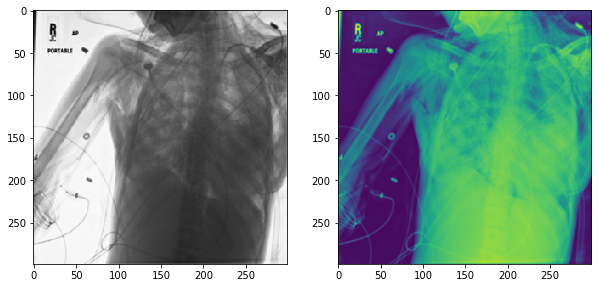

In [32]:
from PIL import Image,ImageOps
import matplotlib.pyplot as plt
image_test=r"..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2173.png"
im=Image.open(image_test)
def compare_images(im1):
    fig,(ax1,ax2)=plt.subplots(1,2)
    fig.set_size_inches(10,10)
    ax1.imshow(im1,cmap="binary",interpolation="nearest")
    ax2.imshow(im1,cmap="viridis")
    plt.show()
compare_images(im)

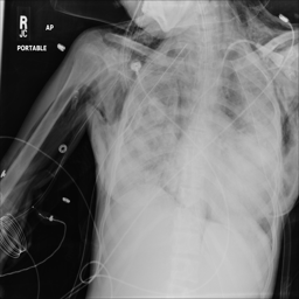

In [33]:
display(im)

In [34]:
import numpy as np

np.array(im)

array([[171, 190, 189, ...,  37,  35,  29],
       [196, 219, 216, ...,  40,  36,  31],
       [201, 223, 220, ...,  37,  35,  32],
       ...,
       [ 29,  26,  20, ...,  14,  15,  14],
       [ 19,  21,  20, ...,  12,  13,  12],
       [ 10,  13,  13, ...,  10,  11,  10]], dtype=uint8)

* A esta

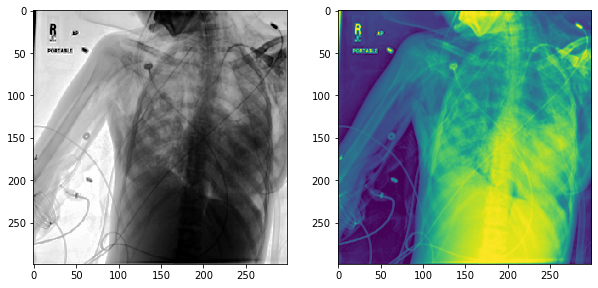

In [35]:
im_eq=ImageOps.equalize(im,mask=None)
compare_images(im_eq)

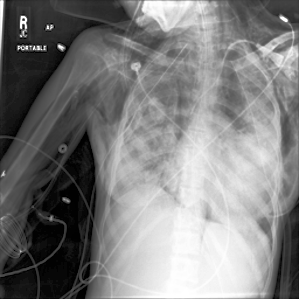

In [36]:
display(im_eq)

In [37]:
np.array(im_eq)

array([[183, 228, 226, ...,  63,  62,  56],
       [240, 255, 255, ...,  65,  62,  58],
       [250, 255, 255, ...,  63,  62,  59],
       ...,
       [ 56,  53,  46, ...,  36,  38,  36],
       [ 44,  47,  46, ...,  27,  32,  27],
       [ 20,  32,  32, ...,  20,  24,  20]], dtype=uint8)

### EQUALIZACION DE IMAGENES

* Reemplazamos cada imagen con su respectiva forma ecualizada.

In [50]:
import os

path_train=r"..\Datasets\train"
path_val=r"..\Datasets\val"
path_test=r"..\Datasets\test"
#funcion que acepta la raiz prin
def equalize(path):
    im=Image.open(path)
    im=ImageOps.equalize(im,mask=None)
    im.save(path)
    print(path,"EQUALIZADA")
    
def dir_equalization(root_path):
    for (root,directories,file_path) in os.walk(root_path):
        for directory in directories:
            dir_path=os.path.join(root,directory)
            for img_path in os.scandir(dir_path):
                equalize(img_path.path)


In [51]:
dir_equalization(path_train)

..\Datasets\train\COVID\COVID-1.png EQUALIZADA
..\Datasets\train\COVID\COVID-100.png EQUALIZADA
..\Datasets\train\COVID\COVID-1000.png EQUALIZADA
..\Datasets\train\COVID\COVID-1002.png EQUALIZADA
..\Datasets\train\COVID\COVID-1003.png EQUALIZADA
..\Datasets\train\COVID\COVID-1004.png EQUALIZADA
..\Datasets\train\COVID\COVID-1005.png EQUALIZADA
..\Datasets\train\COVID\COVID-1006.png EQUALIZADA
..\Datasets\train\COVID\COVID-1007.png EQUALIZADA
..\Datasets\train\COVID\COVID-101.png EQUALIZADA
..\Datasets\train\COVID\COVID-1011.png EQUALIZADA
..\Datasets\train\COVID\COVID-1013.png EQUALIZADA
..\Datasets\train\COVID\COVID-1014.png EQUALIZADA
..\Datasets\train\COVID\COVID-1016.png EQUALIZADA
..\Datasets\train\COVID\COVID-1018.png EQUALIZADA
..\Datasets\train\COVID\COVID-1019.png EQUALIZADA
..\Datasets\train\COVID\COVID-102.png EQUALIZADA
..\Datasets\train\COVID\COVID-1021.png EQUALIZADA
..\Datasets\train\COVID\COVID-1023.png EQUALIZADA
..\Datasets\train\COVID\COVID-1025.png EQUALIZADA
..\Dat

..\Datasets\train\COVID\COVID-1202.png EQUALIZADA
..\Datasets\train\COVID\COVID-1203.png EQUALIZADA
..\Datasets\train\COVID\COVID-1204.png EQUALIZADA
..\Datasets\train\COVID\COVID-1205.png EQUALIZADA
..\Datasets\train\COVID\COVID-1206.png EQUALIZADA
..\Datasets\train\COVID\COVID-1207.png EQUALIZADA
..\Datasets\train\COVID\COVID-1208.png EQUALIZADA
..\Datasets\train\COVID\COVID-121.png EQUALIZADA
..\Datasets\train\COVID\COVID-1210.png EQUALIZADA
..\Datasets\train\COVID\COVID-1211.png EQUALIZADA
..\Datasets\train\COVID\COVID-1212.png EQUALIZADA
..\Datasets\train\COVID\COVID-1213.png EQUALIZADA
..\Datasets\train\COVID\COVID-1216.png EQUALIZADA
..\Datasets\train\COVID\COVID-1217.png EQUALIZADA
..\Datasets\train\COVID\COVID-1218.png EQUALIZADA
..\Datasets\train\COVID\COVID-122.png EQUALIZADA
..\Datasets\train\COVID\COVID-1221.png EQUALIZADA
..\Datasets\train\COVID\COVID-1222.png EQUALIZADA
..\Datasets\train\COVID\COVID-1223.png EQUALIZADA
..\Datasets\train\COVID\COVID-1224.png EQUALIZADA
..

..\Datasets\train\COVID\COVID-1404.png EQUALIZADA
..\Datasets\train\COVID\COVID-1406.png EQUALIZADA
..\Datasets\train\COVID\COVID-1407.png EQUALIZADA
..\Datasets\train\COVID\COVID-1409.png EQUALIZADA
..\Datasets\train\COVID\COVID-1410.png EQUALIZADA
..\Datasets\train\COVID\COVID-1412.png EQUALIZADA
..\Datasets\train\COVID\COVID-1413.png EQUALIZADA
..\Datasets\train\COVID\COVID-1414.png EQUALIZADA
..\Datasets\train\COVID\COVID-1415.png EQUALIZADA
..\Datasets\train\COVID\COVID-1416.png EQUALIZADA
..\Datasets\train\COVID\COVID-1417.png EQUALIZADA
..\Datasets\train\COVID\COVID-142.png EQUALIZADA
..\Datasets\train\COVID\COVID-1421.png EQUALIZADA
..\Datasets\train\COVID\COVID-1423.png EQUALIZADA
..\Datasets\train\COVID\COVID-1424.png EQUALIZADA
..\Datasets\train\COVID\COVID-1426.png EQUALIZADA
..\Datasets\train\COVID\COVID-1427.png EQUALIZADA
..\Datasets\train\COVID\COVID-1428.png EQUALIZADA
..\Datasets\train\COVID\COVID-1429.png EQUALIZADA
..\Datasets\train\COVID\COVID-1430.png EQUALIZADA
.

..\Datasets\train\COVID\COVID-1621.png EQUALIZADA
..\Datasets\train\COVID\COVID-1622.png EQUALIZADA
..\Datasets\train\COVID\COVID-1623.png EQUALIZADA
..\Datasets\train\COVID\COVID-1624.png EQUALIZADA
..\Datasets\train\COVID\COVID-1625.png EQUALIZADA
..\Datasets\train\COVID\COVID-1626.png EQUALIZADA
..\Datasets\train\COVID\COVID-1629.png EQUALIZADA
..\Datasets\train\COVID\COVID-163.png EQUALIZADA
..\Datasets\train\COVID\COVID-1632.png EQUALIZADA
..\Datasets\train\COVID\COVID-1633.png EQUALIZADA
..\Datasets\train\COVID\COVID-1634.png EQUALIZADA
..\Datasets\train\COVID\COVID-1635.png EQUALIZADA
..\Datasets\train\COVID\COVID-1636.png EQUALIZADA
..\Datasets\train\COVID\COVID-1638.png EQUALIZADA
..\Datasets\train\COVID\COVID-1639.png EQUALIZADA
..\Datasets\train\COVID\COVID-1641.png EQUALIZADA
..\Datasets\train\COVID\COVID-1642.png EQUALIZADA
..\Datasets\train\COVID\COVID-1643.png EQUALIZADA
..\Datasets\train\COVID\COVID-1645.png EQUALIZADA
..\Datasets\train\COVID\COVID-1646.png EQUALIZADA
.

..\Datasets\train\COVID\COVID-183.png EQUALIZADA
..\Datasets\train\COVID\COVID-1830.png EQUALIZADA
..\Datasets\train\COVID\COVID-1831.png EQUALIZADA
..\Datasets\train\COVID\COVID-1832.png EQUALIZADA
..\Datasets\train\COVID\COVID-1833.png EQUALIZADA
..\Datasets\train\COVID\COVID-1834.png EQUALIZADA
..\Datasets\train\COVID\COVID-1835.png EQUALIZADA
..\Datasets\train\COVID\COVID-1836.png EQUALIZADA
..\Datasets\train\COVID\COVID-1837.png EQUALIZADA
..\Datasets\train\COVID\COVID-1838.png EQUALIZADA
..\Datasets\train\COVID\COVID-1839.png EQUALIZADA
..\Datasets\train\COVID\COVID-1840.png EQUALIZADA
..\Datasets\train\COVID\COVID-1842.png EQUALIZADA
..\Datasets\train\COVID\COVID-1843.png EQUALIZADA
..\Datasets\train\COVID\COVID-1844.png EQUALIZADA
..\Datasets\train\COVID\COVID-1845.png EQUALIZADA
..\Datasets\train\COVID\COVID-1846.png EQUALIZADA
..\Datasets\train\COVID\COVID-1847.png EQUALIZADA
..\Datasets\train\COVID\COVID-1848.png EQUALIZADA
..\Datasets\train\COVID\COVID-1849.png EQUALIZADA
.

..\Datasets\train\COVID\COVID-2240.png EQUALIZADA
..\Datasets\train\COVID\COVID-2241.png EQUALIZADA
..\Datasets\train\COVID\COVID-2242.png EQUALIZADA
..\Datasets\train\COVID\COVID-2243.png EQUALIZADA
..\Datasets\train\COVID\COVID-2245.png EQUALIZADA
..\Datasets\train\COVID\COVID-2246.png EQUALIZADA
..\Datasets\train\COVID\COVID-2247.png EQUALIZADA
..\Datasets\train\COVID\COVID-2251.png EQUALIZADA
..\Datasets\train\COVID\COVID-2252.png EQUALIZADA
..\Datasets\train\COVID\COVID-2253.png EQUALIZADA
..\Datasets\train\COVID\COVID-2254.png EQUALIZADA
..\Datasets\train\COVID\COVID-2255.png EQUALIZADA
..\Datasets\train\COVID\COVID-2257.png EQUALIZADA
..\Datasets\train\COVID\COVID-2258.png EQUALIZADA
..\Datasets\train\COVID\COVID-226.png EQUALIZADA
..\Datasets\train\COVID\COVID-2260.png EQUALIZADA
..\Datasets\train\COVID\COVID-2261.png EQUALIZADA
..\Datasets\train\COVID\COVID-2262.png EQUALIZADA
..\Datasets\train\COVID\COVID-2263.png EQUALIZADA
..\Datasets\train\COVID\COVID-2264.png EQUALIZADA
.

..\Datasets\train\COVID\COVID-2661.png EQUALIZADA
..\Datasets\train\COVID\COVID-2662.png EQUALIZADA
..\Datasets\train\COVID\COVID-2663.png EQUALIZADA
..\Datasets\train\COVID\COVID-2664.png EQUALIZADA
..\Datasets\train\COVID\COVID-2665.png EQUALIZADA
..\Datasets\train\COVID\COVID-2666.png EQUALIZADA
..\Datasets\train\COVID\COVID-2669.png EQUALIZADA
..\Datasets\train\COVID\COVID-2670.png EQUALIZADA
..\Datasets\train\COVID\COVID-2671.png EQUALIZADA
..\Datasets\train\COVID\COVID-2672.png EQUALIZADA
..\Datasets\train\COVID\COVID-2673.png EQUALIZADA
..\Datasets\train\COVID\COVID-2674.png EQUALIZADA
..\Datasets\train\COVID\COVID-2675.png EQUALIZADA
..\Datasets\train\COVID\COVID-2677.png EQUALIZADA
..\Datasets\train\COVID\COVID-2678.png EQUALIZADA
..\Datasets\train\COVID\COVID-2679.png EQUALIZADA
..\Datasets\train\COVID\COVID-268.png EQUALIZADA
..\Datasets\train\COVID\COVID-2680.png EQUALIZADA
..\Datasets\train\COVID\COVID-2682.png EQUALIZADA
..\Datasets\train\COVID\COVID-2683.png EQUALIZADA
.

..\Datasets\train\COVID\COVID-2869.png EQUALIZADA
..\Datasets\train\COVID\COVID-2870.png EQUALIZADA
..\Datasets\train\COVID\COVID-2871.png EQUALIZADA
..\Datasets\train\COVID\COVID-2872.png EQUALIZADA
..\Datasets\train\COVID\COVID-2874.png EQUALIZADA
..\Datasets\train\COVID\COVID-2875.png EQUALIZADA
..\Datasets\train\COVID\COVID-2878.png EQUALIZADA
..\Datasets\train\COVID\COVID-288.png EQUALIZADA
..\Datasets\train\COVID\COVID-2880.png EQUALIZADA
..\Datasets\train\COVID\COVID-2881.png EQUALIZADA
..\Datasets\train\COVID\COVID-2882.png EQUALIZADA
..\Datasets\train\COVID\COVID-2883.png EQUALIZADA
..\Datasets\train\COVID\COVID-2884.png EQUALIZADA
..\Datasets\train\COVID\COVID-2885.png EQUALIZADA
..\Datasets\train\COVID\COVID-2886.png EQUALIZADA
..\Datasets\train\COVID\COVID-2887.png EQUALIZADA
..\Datasets\train\COVID\COVID-2888.png EQUALIZADA
..\Datasets\train\COVID\COVID-2889.png EQUALIZADA
..\Datasets\train\COVID\COVID-289.png EQUALIZADA
..\Datasets\train\COVID\COVID-2891.png EQUALIZADA
..

..\Datasets\train\COVID\COVID-3056.png EQUALIZADA
..\Datasets\train\COVID\COVID-3057.png EQUALIZADA
..\Datasets\train\COVID\COVID-3059.png EQUALIZADA
..\Datasets\train\COVID\COVID-306.png EQUALIZADA
..\Datasets\train\COVID\COVID-3061.png EQUALIZADA
..\Datasets\train\COVID\COVID-3062.png EQUALIZADA
..\Datasets\train\COVID\COVID-3064.png EQUALIZADA
..\Datasets\train\COVID\COVID-3065.png EQUALIZADA
..\Datasets\train\COVID\COVID-3066.png EQUALIZADA
..\Datasets\train\COVID\COVID-3068.png EQUALIZADA
..\Datasets\train\COVID\COVID-3070.png EQUALIZADA
..\Datasets\train\COVID\COVID-3071.png EQUALIZADA
..\Datasets\train\COVID\COVID-3072.png EQUALIZADA
..\Datasets\train\COVID\COVID-3074.png EQUALIZADA
..\Datasets\train\COVID\COVID-3075.png EQUALIZADA
..\Datasets\train\COVID\COVID-3076.png EQUALIZADA
..\Datasets\train\COVID\COVID-3077.png EQUALIZADA
..\Datasets\train\COVID\COVID-308.png EQUALIZADA
..\Datasets\train\COVID\COVID-3080.png EQUALIZADA
..\Datasets\train\COVID\COVID-3081.png EQUALIZADA
..

..\Datasets\train\COVID\COVID-3262.png EQUALIZADA
..\Datasets\train\COVID\COVID-3263.png EQUALIZADA
..\Datasets\train\COVID\COVID-3264.png EQUALIZADA
..\Datasets\train\COVID\COVID-3266.png EQUALIZADA
..\Datasets\train\COVID\COVID-3271.png EQUALIZADA
..\Datasets\train\COVID\COVID-3272.png EQUALIZADA
..\Datasets\train\COVID\COVID-3275.png EQUALIZADA
..\Datasets\train\COVID\COVID-3276.png EQUALIZADA
..\Datasets\train\COVID\COVID-3277.png EQUALIZADA
..\Datasets\train\COVID\COVID-3279.png EQUALIZADA
..\Datasets\train\COVID\COVID-328.png EQUALIZADA
..\Datasets\train\COVID\COVID-3280.png EQUALIZADA
..\Datasets\train\COVID\COVID-3281.png EQUALIZADA
..\Datasets\train\COVID\COVID-3283.png EQUALIZADA
..\Datasets\train\COVID\COVID-3285.png EQUALIZADA
..\Datasets\train\COVID\COVID-3286.png EQUALIZADA
..\Datasets\train\COVID\COVID-3287.png EQUALIZADA
..\Datasets\train\COVID\COVID-329.png EQUALIZADA
..\Datasets\train\COVID\COVID-3291.png EQUALIZADA
..\Datasets\train\COVID\COVID-3293.png EQUALIZADA
..

..\Datasets\train\COVID\COVID-3474.png EQUALIZADA
..\Datasets\train\COVID\COVID-3475.png EQUALIZADA
..\Datasets\train\COVID\COVID-3476.png EQUALIZADA
..\Datasets\train\COVID\COVID-3477.png EQUALIZADA
..\Datasets\train\COVID\COVID-3478.png EQUALIZADA
..\Datasets\train\COVID\COVID-3479.png EQUALIZADA
..\Datasets\train\COVID\COVID-348.png EQUALIZADA
..\Datasets\train\COVID\COVID-3480.png EQUALIZADA
..\Datasets\train\COVID\COVID-3481.png EQUALIZADA
..\Datasets\train\COVID\COVID-3482.png EQUALIZADA
..\Datasets\train\COVID\COVID-3483.png EQUALIZADA
..\Datasets\train\COVID\COVID-3484.png EQUALIZADA
..\Datasets\train\COVID\COVID-3485.png EQUALIZADA
..\Datasets\train\COVID\COVID-3486.png EQUALIZADA
..\Datasets\train\COVID\COVID-3487.png EQUALIZADA
..\Datasets\train\COVID\COVID-3488.png EQUALIZADA
..\Datasets\train\COVID\COVID-3489.png EQUALIZADA
..\Datasets\train\COVID\COVID-3490.png EQUALIZADA
..\Datasets\train\COVID\COVID-3491.png EQUALIZADA
..\Datasets\train\COVID\COVID-3492.png EQUALIZADA
.

..\Datasets\train\COVID\COVID-441.png EQUALIZADA
..\Datasets\train\COVID\COVID-442.png EQUALIZADA
..\Datasets\train\COVID\COVID-445.png EQUALIZADA
..\Datasets\train\COVID\COVID-45.png EQUALIZADA
..\Datasets\train\COVID\COVID-450.png EQUALIZADA
..\Datasets\train\COVID\COVID-451.png EQUALIZADA
..\Datasets\train\COVID\COVID-453.png EQUALIZADA
..\Datasets\train\COVID\COVID-454.png EQUALIZADA
..\Datasets\train\COVID\COVID-455.png EQUALIZADA
..\Datasets\train\COVID\COVID-456.png EQUALIZADA
..\Datasets\train\COVID\COVID-457.png EQUALIZADA
..\Datasets\train\COVID\COVID-458.png EQUALIZADA
..\Datasets\train\COVID\COVID-459.png EQUALIZADA
..\Datasets\train\COVID\COVID-46.png EQUALIZADA
..\Datasets\train\COVID\COVID-460.png EQUALIZADA
..\Datasets\train\COVID\COVID-462.png EQUALIZADA
..\Datasets\train\COVID\COVID-463.png EQUALIZADA
..\Datasets\train\COVID\COVID-464.png EQUALIZADA
..\Datasets\train\COVID\COVID-466.png EQUALIZADA
..\Datasets\train\COVID\COVID-467.png EQUALIZADA
..\Datasets\train\COVI

..\Datasets\train\COVID\COVID-653.png EQUALIZADA
..\Datasets\train\COVID\COVID-654.png EQUALIZADA
..\Datasets\train\COVID\COVID-656.png EQUALIZADA
..\Datasets\train\COVID\COVID-657.png EQUALIZADA
..\Datasets\train\COVID\COVID-658.png EQUALIZADA
..\Datasets\train\COVID\COVID-659.png EQUALIZADA
..\Datasets\train\COVID\COVID-661.png EQUALIZADA
..\Datasets\train\COVID\COVID-663.png EQUALIZADA
..\Datasets\train\COVID\COVID-664.png EQUALIZADA
..\Datasets\train\COVID\COVID-665.png EQUALIZADA
..\Datasets\train\COVID\COVID-666.png EQUALIZADA
..\Datasets\train\COVID\COVID-667.png EQUALIZADA
..\Datasets\train\COVID\COVID-668.png EQUALIZADA
..\Datasets\train\COVID\COVID-669.png EQUALIZADA
..\Datasets\train\COVID\COVID-67.png EQUALIZADA
..\Datasets\train\COVID\COVID-670.png EQUALIZADA
..\Datasets\train\COVID\COVID-671.png EQUALIZADA
..\Datasets\train\COVID\COVID-672.png EQUALIZADA
..\Datasets\train\COVID\COVID-673.png EQUALIZADA
..\Datasets\train\COVID\COVID-675.png EQUALIZADA
..\Datasets\train\COV

..\Datasets\train\COVID\COVID-880.png EQUALIZADA
..\Datasets\train\COVID\COVID-882.png EQUALIZADA
..\Datasets\train\COVID\COVID-883.png EQUALIZADA
..\Datasets\train\COVID\COVID-884.png EQUALIZADA
..\Datasets\train\COVID\COVID-885.png EQUALIZADA
..\Datasets\train\COVID\COVID-887.png EQUALIZADA
..\Datasets\train\COVID\COVID-889.png EQUALIZADA
..\Datasets\train\COVID\COVID-890.png EQUALIZADA
..\Datasets\train\COVID\COVID-891.png EQUALIZADA
..\Datasets\train\COVID\COVID-892.png EQUALIZADA
..\Datasets\train\COVID\COVID-893.png EQUALIZADA
..\Datasets\train\COVID\COVID-895.png EQUALIZADA
..\Datasets\train\COVID\COVID-897.png EQUALIZADA
..\Datasets\train\COVID\COVID-898.png EQUALIZADA
..\Datasets\train\COVID\COVID-899.png EQUALIZADA
..\Datasets\train\COVID\COVID-9.png EQUALIZADA
..\Datasets\train\COVID\COVID-904.png EQUALIZADA
..\Datasets\train\COVID\COVID-905.png EQUALIZADA
..\Datasets\train\COVID\COVID-907.png EQUALIZADA
..\Datasets\train\COVID\COVID-910.png EQUALIZADA
..\Datasets\train\COVI

..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-1058.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-106.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-1060.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-1061.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-1062.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-1064.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-1065.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-1066.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-1068.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-1069.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-107.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lun

..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-1297.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-1298.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-1299.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-13.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-130.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-1300.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-1301.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-1302.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-1303.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-1304.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-1306.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung

..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-1409.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-141.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-1410.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-1411.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-1413.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-1414.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-1415.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-1416.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-1417.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-1418.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-1419.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lu

..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-1548.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-1549.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-155.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-1550.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-1553.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-1554.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-1555.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-1558.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-156.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-1561.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-1562.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lun

..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-1677.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-1678.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-168.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-1680.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-1681.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-1682.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-1683.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-1684.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-1685.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-1686.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-1687.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lu

..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-1902.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-1903.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-1905.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-1906.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-1908.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-191.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-1910.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-1912.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-1913.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-1914.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-1915.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lu

..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2026.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2027.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2028.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2029.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-203.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2030.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2031.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2032.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2033.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2035.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2036.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lu

..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2139.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-214.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2140.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2141.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2143.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2144.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2145.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2147.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2148.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2149.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2150.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lu

..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2264.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2265.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2266.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2267.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2268.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2269.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2270.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2271.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2273.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2275.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2276.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\L

..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2375.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2376.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2377.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2378.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2379.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-238.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2380.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2381.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2386.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2387.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-239.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lun

..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2492.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2493.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2495.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2496.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2497.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2498.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2499.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-25.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2500.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2501.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2502.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lun

..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-261.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2610.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2612.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2613.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2614.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2615.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2616.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2617.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2618.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2619.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-262.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lun

..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2737.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-274.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2740.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2741.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2742.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2744.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2745.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2746.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2747.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2748.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2749.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lu

..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2862.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2863.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2864.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2865.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2866.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2867.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2868.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2869.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2870.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2872.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2873.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\L

..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3091.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3092.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3093.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3094.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3097.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3098.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-31.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-310.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3100.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3101.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3106.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung

..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3216.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3217.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3218.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3221.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3222.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3224.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3225.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3227.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3229.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-323.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3231.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lu

..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3354.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3356.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3357.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3359.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-336.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3362.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3363.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3364.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3365.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3366.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3367.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lu

..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3482.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3483.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3487.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-349.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3491.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3492.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3493.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3494.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3497.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3498.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3499.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lu

..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3620.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3621.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3624.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3625.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3627.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3628.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3629.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3631.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3632.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3633.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3635.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\L

..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3738.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3739.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-374.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3741.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3742.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3743.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3744.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3745.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3746.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3747.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3748.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lu

..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3848.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3849.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3851.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3852.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3854.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3856.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3857.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3858.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3859.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-386.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3860.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lu

..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3974.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3976.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3977.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3978.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-398.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3980.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3983.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3984.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3985.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3987.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-3988.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lu

..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-410.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4100.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4101.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4102.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4104.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4105.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4107.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4108.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4109.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-411.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4110.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lun

..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4229.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-423.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4231.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4232.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4233.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4234.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4236.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4237.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4239.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4240.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4241.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lu

..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-437.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4370.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4371.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4373.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4374.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4377.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4378.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4379.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-438.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4383.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4384.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lun

..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-45.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4500.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4501.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4503.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4504.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4506.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4507.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4509.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4510.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4511.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4513.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lun

..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4632.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4633.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4634.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4635.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4636.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4637.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4638.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4639.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-464.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4641.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4642.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lu

..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4744.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4745.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4746.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4748.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-475.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4751.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4752.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4753.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4756.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4757.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4758.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lu

..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4865.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4866.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4867.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4868.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-487.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4870.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4871.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4873.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4874.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4875.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-488.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lun

..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4987.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4988.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4989.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4991.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4992.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4993.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4994.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4995.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4996.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4997.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-4998.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\L

..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5112.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5113.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5114.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5115.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5116.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5118.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5119.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5120.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5121.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5122.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5123.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\L

..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-523.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5230.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5232.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5233.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5234.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5236.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5237.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5238.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-524.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5242.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5243.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lun

..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5359.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-536.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5360.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5361.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5365.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5366.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-537.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5370.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5372.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5373.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5374.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lun

..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5488.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5489.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-549.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5492.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5493.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5495.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5496.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5498.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5499.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-55.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5501.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung

..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5624.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5625.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5627.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5628.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5629.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-563.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5632.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5633.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5634.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5635.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5637.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lu

..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5745.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5747.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5749.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-575.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5750.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5751.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5752.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5753.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5754.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5755.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5759.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lu

..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5863.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5865.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5866.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5867.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5869.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-587.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5870.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5871.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5872.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5873.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5874.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lu

..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5989.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5990.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5992.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5993.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5994.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5995.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5996.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-5999.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-60.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-600.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-6000.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung

..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-70.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-700.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-702.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-703.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-706.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-708.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-71.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-710.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-711.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-712.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-714.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-7

..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-827.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-828.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-83.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-831.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-832.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-836.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-838.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-839.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-840.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-841.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-842.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-

..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-962.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-963.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-964.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-966.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-968.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-969.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-970.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-971.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-972.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-973.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-974.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity

..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-1074.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-1075.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-1076.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-1077.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-1078.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-1079.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-108.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-1080.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-1082.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-1083.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-1086.png EQUALIZADA
..\Datasets\train\Enfe

..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-1205.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-1206.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-1208.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-1209.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-121.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-1210.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-1211.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-1212.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-1213.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-1214.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-1215.png EQUALIZADA
..\Datasets\train\Enfe

..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-1336.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-1337.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-1339.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-134.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-1340.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-1342.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-1343.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-1345.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-135.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-136.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-138.png EQUALIZADA
..\Datasets\train\Enferme

..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-247.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-248.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-249.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-25.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-250.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-251.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-252.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-253.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-254.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-255.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-257.png EQUALIZADA
..\Datasets\train\Enfermedades Pu

..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-359.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-36.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-361.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-362.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-363.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-364.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-366.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-368.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-371.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-372.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-374.png EQUALIZADA
..\Datasets\train\Enfermedades Pu

..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-480.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-481.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-482.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-485.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-486.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-487.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-49.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-490.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-491.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-492.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-494.png EQUALIZADA
..\Datasets\train\Enfermedades Pu

..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-601.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-602.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-603.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-604.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-605.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-606.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-607.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-608.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-609.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-61.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-610.png EQUALIZADA
..\Datasets\train\Enfermedades Pu

..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-722.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-723.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-724.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-725.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-726.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-727.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-728.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-729.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-730.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-731.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-732.png EQUALIZADA
..\Datasets\train\Enfermedades P

..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-840.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-841.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-842.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-843.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-845.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-847.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-848.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-849.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-85.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-852.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-853.png EQUALIZADA
..\Datasets\train\Enfermedades Pu

..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-954.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-955.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-956.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-957.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-959.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-96.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-960.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-962.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-963.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-968.png EQUALIZADA
..\Datasets\train\Enfermedades Pulmonares No COVID19\Viral Pneumonia-969.png EQUALIZADA
..\Datasets\train\Enfermedades Pu

..\Datasets\train\Normal\Normal-10125.png EQUALIZADA
..\Datasets\train\Normal\Normal-10128.png EQUALIZADA
..\Datasets\train\Normal\Normal-10129.png EQUALIZADA
..\Datasets\train\Normal\Normal-1013.png EQUALIZADA
..\Datasets\train\Normal\Normal-10131.png EQUALIZADA
..\Datasets\train\Normal\Normal-10132.png EQUALIZADA
..\Datasets\train\Normal\Normal-10133.png EQUALIZADA
..\Datasets\train\Normal\Normal-10134.png EQUALIZADA
..\Datasets\train\Normal\Normal-10137.png EQUALIZADA
..\Datasets\train\Normal\Normal-10138.png EQUALIZADA
..\Datasets\train\Normal\Normal-10139.png EQUALIZADA
..\Datasets\train\Normal\Normal-1014.png EQUALIZADA
..\Datasets\train\Normal\Normal-10140.png EQUALIZADA
..\Datasets\train\Normal\Normal-10141.png EQUALIZADA
..\Datasets\train\Normal\Normal-10142.png EQUALIZADA
..\Datasets\train\Normal\Normal-10143.png EQUALIZADA
..\Datasets\train\Normal\Normal-10144.png EQUALIZADA
..\Datasets\train\Normal\Normal-10145.png EQUALIZADA
..\Datasets\train\Normal\Normal-10146.png EQUALI

..\Datasets\train\Normal\Normal-1146.png EQUALIZADA
..\Datasets\train\Normal\Normal-1148.png EQUALIZADA
..\Datasets\train\Normal\Normal-1149.png EQUALIZADA
..\Datasets\train\Normal\Normal-115.png EQUALIZADA
..\Datasets\train\Normal\Normal-1150.png EQUALIZADA
..\Datasets\train\Normal\Normal-1151.png EQUALIZADA
..\Datasets\train\Normal\Normal-1153.png EQUALIZADA
..\Datasets\train\Normal\Normal-1154.png EQUALIZADA
..\Datasets\train\Normal\Normal-1155.png EQUALIZADA
..\Datasets\train\Normal\Normal-1156.png EQUALIZADA
..\Datasets\train\Normal\Normal-1157.png EQUALIZADA
..\Datasets\train\Normal\Normal-1158.png EQUALIZADA
..\Datasets\train\Normal\Normal-1159.png EQUALIZADA
..\Datasets\train\Normal\Normal-1160.png EQUALIZADA
..\Datasets\train\Normal\Normal-1161.png EQUALIZADA
..\Datasets\train\Normal\Normal-1163.png EQUALIZADA
..\Datasets\train\Normal\Normal-1164.png EQUALIZADA
..\Datasets\train\Normal\Normal-1165.png EQUALIZADA
..\Datasets\train\Normal\Normal-1166.png EQUALIZADA
..\Datasets\t

..\Datasets\train\Normal\Normal-1346.png EQUALIZADA
..\Datasets\train\Normal\Normal-1347.png EQUALIZADA
..\Datasets\train\Normal\Normal-1348.png EQUALIZADA
..\Datasets\train\Normal\Normal-135.png EQUALIZADA
..\Datasets\train\Normal\Normal-1350.png EQUALIZADA
..\Datasets\train\Normal\Normal-1351.png EQUALIZADA
..\Datasets\train\Normal\Normal-1352.png EQUALIZADA
..\Datasets\train\Normal\Normal-1353.png EQUALIZADA
..\Datasets\train\Normal\Normal-1355.png EQUALIZADA
..\Datasets\train\Normal\Normal-1356.png EQUALIZADA
..\Datasets\train\Normal\Normal-1359.png EQUALIZADA
..\Datasets\train\Normal\Normal-1360.png EQUALIZADA
..\Datasets\train\Normal\Normal-1362.png EQUALIZADA
..\Datasets\train\Normal\Normal-1366.png EQUALIZADA
..\Datasets\train\Normal\Normal-1369.png EQUALIZADA
..\Datasets\train\Normal\Normal-137.png EQUALIZADA
..\Datasets\train\Normal\Normal-1370.png EQUALIZADA
..\Datasets\train\Normal\Normal-1372.png EQUALIZADA
..\Datasets\train\Normal\Normal-1374.png EQUALIZADA
..\Datasets\tr

..\Datasets\train\Normal\Normal-1567.png EQUALIZADA
..\Datasets\train\Normal\Normal-1568.png EQUALIZADA
..\Datasets\train\Normal\Normal-1569.png EQUALIZADA
..\Datasets\train\Normal\Normal-157.png EQUALIZADA
..\Datasets\train\Normal\Normal-1570.png EQUALIZADA
..\Datasets\train\Normal\Normal-1571.png EQUALIZADA
..\Datasets\train\Normal\Normal-1572.png EQUALIZADA
..\Datasets\train\Normal\Normal-1573.png EQUALIZADA
..\Datasets\train\Normal\Normal-1575.png EQUALIZADA
..\Datasets\train\Normal\Normal-1576.png EQUALIZADA
..\Datasets\train\Normal\Normal-1577.png EQUALIZADA
..\Datasets\train\Normal\Normal-1578.png EQUALIZADA
..\Datasets\train\Normal\Normal-1579.png EQUALIZADA
..\Datasets\train\Normal\Normal-158.png EQUALIZADA
..\Datasets\train\Normal\Normal-1580.png EQUALIZADA
..\Datasets\train\Normal\Normal-1582.png EQUALIZADA
..\Datasets\train\Normal\Normal-1583.png EQUALIZADA
..\Datasets\train\Normal\Normal-1584.png EQUALIZADA
..\Datasets\train\Normal\Normal-1586.png EQUALIZADA
..\Datasets\tr

..\Datasets\train\Normal\Normal-1758.png EQUALIZADA
..\Datasets\train\Normal\Normal-1759.png EQUALIZADA
..\Datasets\train\Normal\Normal-176.png EQUALIZADA
..\Datasets\train\Normal\Normal-1760.png EQUALIZADA
..\Datasets\train\Normal\Normal-1763.png EQUALIZADA
..\Datasets\train\Normal\Normal-1764.png EQUALIZADA
..\Datasets\train\Normal\Normal-1765.png EQUALIZADA
..\Datasets\train\Normal\Normal-1766.png EQUALIZADA
..\Datasets\train\Normal\Normal-1768.png EQUALIZADA
..\Datasets\train\Normal\Normal-1769.png EQUALIZADA
..\Datasets\train\Normal\Normal-177.png EQUALIZADA
..\Datasets\train\Normal\Normal-1771.png EQUALIZADA
..\Datasets\train\Normal\Normal-1772.png EQUALIZADA
..\Datasets\train\Normal\Normal-1773.png EQUALIZADA
..\Datasets\train\Normal\Normal-1776.png EQUALIZADA
..\Datasets\train\Normal\Normal-1777.png EQUALIZADA
..\Datasets\train\Normal\Normal-1779.png EQUALIZADA
..\Datasets\train\Normal\Normal-178.png EQUALIZADA
..\Datasets\train\Normal\Normal-1780.png EQUALIZADA
..\Datasets\tra

..\Datasets\train\Normal\Normal-1953.png EQUALIZADA
..\Datasets\train\Normal\Normal-1954.png EQUALIZADA
..\Datasets\train\Normal\Normal-1955.png EQUALIZADA
..\Datasets\train\Normal\Normal-1956.png EQUALIZADA
..\Datasets\train\Normal\Normal-1958.png EQUALIZADA
..\Datasets\train\Normal\Normal-196.png EQUALIZADA
..\Datasets\train\Normal\Normal-1960.png EQUALIZADA
..\Datasets\train\Normal\Normal-1961.png EQUALIZADA
..\Datasets\train\Normal\Normal-1962.png EQUALIZADA
..\Datasets\train\Normal\Normal-1966.png EQUALIZADA
..\Datasets\train\Normal\Normal-1967.png EQUALIZADA
..\Datasets\train\Normal\Normal-1968.png EQUALIZADA
..\Datasets\train\Normal\Normal-1969.png EQUALIZADA
..\Datasets\train\Normal\Normal-1971.png EQUALIZADA
..\Datasets\train\Normal\Normal-1972.png EQUALIZADA
..\Datasets\train\Normal\Normal-1973.png EQUALIZADA
..\Datasets\train\Normal\Normal-1975.png EQUALIZADA
..\Datasets\train\Normal\Normal-1977.png EQUALIZADA
..\Datasets\train\Normal\Normal-1978.png EQUALIZADA
..\Datasets\t

..\Datasets\train\Normal\Normal-2167.png EQUALIZADA
..\Datasets\train\Normal\Normal-2168.png EQUALIZADA
..\Datasets\train\Normal\Normal-2169.png EQUALIZADA
..\Datasets\train\Normal\Normal-2171.png EQUALIZADA
..\Datasets\train\Normal\Normal-2172.png EQUALIZADA
..\Datasets\train\Normal\Normal-2173.png EQUALIZADA
..\Datasets\train\Normal\Normal-2175.png EQUALIZADA
..\Datasets\train\Normal\Normal-2178.png EQUALIZADA
..\Datasets\train\Normal\Normal-218.png EQUALIZADA
..\Datasets\train\Normal\Normal-2180.png EQUALIZADA
..\Datasets\train\Normal\Normal-2181.png EQUALIZADA
..\Datasets\train\Normal\Normal-2182.png EQUALIZADA
..\Datasets\train\Normal\Normal-2184.png EQUALIZADA
..\Datasets\train\Normal\Normal-2185.png EQUALIZADA
..\Datasets\train\Normal\Normal-2186.png EQUALIZADA
..\Datasets\train\Normal\Normal-2187.png EQUALIZADA
..\Datasets\train\Normal\Normal-2188.png EQUALIZADA
..\Datasets\train\Normal\Normal-219.png EQUALIZADA
..\Datasets\train\Normal\Normal-2190.png EQUALIZADA
..\Datasets\tr

..\Datasets\train\Normal\Normal-2361.png EQUALIZADA
..\Datasets\train\Normal\Normal-2362.png EQUALIZADA
..\Datasets\train\Normal\Normal-2364.png EQUALIZADA
..\Datasets\train\Normal\Normal-2365.png EQUALIZADA
..\Datasets\train\Normal\Normal-2366.png EQUALIZADA
..\Datasets\train\Normal\Normal-2367.png EQUALIZADA
..\Datasets\train\Normal\Normal-2368.png EQUALIZADA
..\Datasets\train\Normal\Normal-237.png EQUALIZADA
..\Datasets\train\Normal\Normal-2371.png EQUALIZADA
..\Datasets\train\Normal\Normal-2372.png EQUALIZADA
..\Datasets\train\Normal\Normal-2373.png EQUALIZADA
..\Datasets\train\Normal\Normal-2375.png EQUALIZADA
..\Datasets\train\Normal\Normal-2376.png EQUALIZADA
..\Datasets\train\Normal\Normal-2377.png EQUALIZADA
..\Datasets\train\Normal\Normal-2379.png EQUALIZADA
..\Datasets\train\Normal\Normal-2382.png EQUALIZADA
..\Datasets\train\Normal\Normal-2383.png EQUALIZADA
..\Datasets\train\Normal\Normal-2384.png EQUALIZADA
..\Datasets\train\Normal\Normal-2385.png EQUALIZADA
..\Datasets\t

..\Datasets\train\Normal\Normal-2571.png EQUALIZADA
..\Datasets\train\Normal\Normal-2573.png EQUALIZADA
..\Datasets\train\Normal\Normal-2574.png EQUALIZADA
..\Datasets\train\Normal\Normal-2575.png EQUALIZADA
..\Datasets\train\Normal\Normal-2576.png EQUALIZADA
..\Datasets\train\Normal\Normal-2577.png EQUALIZADA
..\Datasets\train\Normal\Normal-2578.png EQUALIZADA
..\Datasets\train\Normal\Normal-2579.png EQUALIZADA
..\Datasets\train\Normal\Normal-258.png EQUALIZADA
..\Datasets\train\Normal\Normal-2581.png EQUALIZADA
..\Datasets\train\Normal\Normal-2582.png EQUALIZADA
..\Datasets\train\Normal\Normal-2583.png EQUALIZADA
..\Datasets\train\Normal\Normal-2584.png EQUALIZADA
..\Datasets\train\Normal\Normal-2585.png EQUALIZADA
..\Datasets\train\Normal\Normal-2586.png EQUALIZADA
..\Datasets\train\Normal\Normal-2587.png EQUALIZADA
..\Datasets\train\Normal\Normal-2588.png EQUALIZADA
..\Datasets\train\Normal\Normal-2589.png EQUALIZADA
..\Datasets\train\Normal\Normal-2590.png EQUALIZADA
..\Datasets\t

..\Datasets\train\Normal\Normal-2742.png EQUALIZADA
..\Datasets\train\Normal\Normal-2743.png EQUALIZADA
..\Datasets\train\Normal\Normal-2744.png EQUALIZADA
..\Datasets\train\Normal\Normal-2745.png EQUALIZADA
..\Datasets\train\Normal\Normal-2746.png EQUALIZADA
..\Datasets\train\Normal\Normal-2747.png EQUALIZADA
..\Datasets\train\Normal\Normal-2748.png EQUALIZADA
..\Datasets\train\Normal\Normal-2749.png EQUALIZADA
..\Datasets\train\Normal\Normal-275.png EQUALIZADA
..\Datasets\train\Normal\Normal-2750.png EQUALIZADA
..\Datasets\train\Normal\Normal-2751.png EQUALIZADA
..\Datasets\train\Normal\Normal-2754.png EQUALIZADA
..\Datasets\train\Normal\Normal-2755.png EQUALIZADA
..\Datasets\train\Normal\Normal-2756.png EQUALIZADA
..\Datasets\train\Normal\Normal-2758.png EQUALIZADA
..\Datasets\train\Normal\Normal-2759.png EQUALIZADA
..\Datasets\train\Normal\Normal-2760.png EQUALIZADA
..\Datasets\train\Normal\Normal-2761.png EQUALIZADA
..\Datasets\train\Normal\Normal-2762.png EQUALIZADA
..\Datasets\t

..\Datasets\train\Normal\Normal-2936.png EQUALIZADA
..\Datasets\train\Normal\Normal-2937.png EQUALIZADA
..\Datasets\train\Normal\Normal-2939.png EQUALIZADA
..\Datasets\train\Normal\Normal-294.png EQUALIZADA
..\Datasets\train\Normal\Normal-2940.png EQUALIZADA
..\Datasets\train\Normal\Normal-2941.png EQUALIZADA
..\Datasets\train\Normal\Normal-2942.png EQUALIZADA
..\Datasets\train\Normal\Normal-2943.png EQUALIZADA
..\Datasets\train\Normal\Normal-2945.png EQUALIZADA
..\Datasets\train\Normal\Normal-2947.png EQUALIZADA
..\Datasets\train\Normal\Normal-2948.png EQUALIZADA
..\Datasets\train\Normal\Normal-2949.png EQUALIZADA
..\Datasets\train\Normal\Normal-295.png EQUALIZADA
..\Datasets\train\Normal\Normal-2950.png EQUALIZADA
..\Datasets\train\Normal\Normal-2951.png EQUALIZADA
..\Datasets\train\Normal\Normal-2952.png EQUALIZADA
..\Datasets\train\Normal\Normal-2953.png EQUALIZADA
..\Datasets\train\Normal\Normal-2955.png EQUALIZADA
..\Datasets\train\Normal\Normal-2956.png EQUALIZADA
..\Datasets\tr

..\Datasets\train\Normal\Normal-3139.png EQUALIZADA
..\Datasets\train\Normal\Normal-314.png EQUALIZADA
..\Datasets\train\Normal\Normal-3140.png EQUALIZADA
..\Datasets\train\Normal\Normal-3141.png EQUALIZADA
..\Datasets\train\Normal\Normal-3145.png EQUALIZADA
..\Datasets\train\Normal\Normal-3146.png EQUALIZADA
..\Datasets\train\Normal\Normal-3148.png EQUALIZADA
..\Datasets\train\Normal\Normal-315.png EQUALIZADA
..\Datasets\train\Normal\Normal-3150.png EQUALIZADA
..\Datasets\train\Normal\Normal-3151.png EQUALIZADA
..\Datasets\train\Normal\Normal-3153.png EQUALIZADA
..\Datasets\train\Normal\Normal-3155.png EQUALIZADA
..\Datasets\train\Normal\Normal-3157.png EQUALIZADA
..\Datasets\train\Normal\Normal-3158.png EQUALIZADA
..\Datasets\train\Normal\Normal-316.png EQUALIZADA
..\Datasets\train\Normal\Normal-3161.png EQUALIZADA
..\Datasets\train\Normal\Normal-3163.png EQUALIZADA
..\Datasets\train\Normal\Normal-3165.png EQUALIZADA
..\Datasets\train\Normal\Normal-3166.png EQUALIZADA
..\Datasets\tra

..\Datasets\train\Normal\Normal-3350.png EQUALIZADA
..\Datasets\train\Normal\Normal-3351.png EQUALIZADA
..\Datasets\train\Normal\Normal-3353.png EQUALIZADA
..\Datasets\train\Normal\Normal-3355.png EQUALIZADA
..\Datasets\train\Normal\Normal-3356.png EQUALIZADA
..\Datasets\train\Normal\Normal-3357.png EQUALIZADA
..\Datasets\train\Normal\Normal-3358.png EQUALIZADA
..\Datasets\train\Normal\Normal-336.png EQUALIZADA
..\Datasets\train\Normal\Normal-3361.png EQUALIZADA
..\Datasets\train\Normal\Normal-3363.png EQUALIZADA
..\Datasets\train\Normal\Normal-3364.png EQUALIZADA
..\Datasets\train\Normal\Normal-3366.png EQUALIZADA
..\Datasets\train\Normal\Normal-3367.png EQUALIZADA
..\Datasets\train\Normal\Normal-3369.png EQUALIZADA
..\Datasets\train\Normal\Normal-337.png EQUALIZADA
..\Datasets\train\Normal\Normal-3372.png EQUALIZADA
..\Datasets\train\Normal\Normal-3373.png EQUALIZADA
..\Datasets\train\Normal\Normal-3374.png EQUALIZADA
..\Datasets\train\Normal\Normal-3375.png EQUALIZADA
..\Datasets\tr

..\Datasets\train\Normal\Normal-3569.png EQUALIZADA
..\Datasets\train\Normal\Normal-357.png EQUALIZADA
..\Datasets\train\Normal\Normal-3570.png EQUALIZADA
..\Datasets\train\Normal\Normal-3571.png EQUALIZADA
..\Datasets\train\Normal\Normal-3573.png EQUALIZADA
..\Datasets\train\Normal\Normal-3574.png EQUALIZADA
..\Datasets\train\Normal\Normal-3575.png EQUALIZADA
..\Datasets\train\Normal\Normal-3576.png EQUALIZADA
..\Datasets\train\Normal\Normal-3577.png EQUALIZADA
..\Datasets\train\Normal\Normal-3578.png EQUALIZADA
..\Datasets\train\Normal\Normal-3579.png EQUALIZADA
..\Datasets\train\Normal\Normal-3580.png EQUALIZADA
..\Datasets\train\Normal\Normal-3582.png EQUALIZADA
..\Datasets\train\Normal\Normal-3583.png EQUALIZADA
..\Datasets\train\Normal\Normal-3585.png EQUALIZADA
..\Datasets\train\Normal\Normal-3587.png EQUALIZADA
..\Datasets\train\Normal\Normal-3588.png EQUALIZADA
..\Datasets\train\Normal\Normal-3589.png EQUALIZADA
..\Datasets\train\Normal\Normal-3590.png EQUALIZADA
..\Datasets\t

..\Datasets\train\Normal\Normal-3772.png EQUALIZADA
..\Datasets\train\Normal\Normal-3774.png EQUALIZADA
..\Datasets\train\Normal\Normal-3775.png EQUALIZADA
..\Datasets\train\Normal\Normal-3776.png EQUALIZADA
..\Datasets\train\Normal\Normal-3778.png EQUALIZADA
..\Datasets\train\Normal\Normal-378.png EQUALIZADA
..\Datasets\train\Normal\Normal-3780.png EQUALIZADA
..\Datasets\train\Normal\Normal-3781.png EQUALIZADA
..\Datasets\train\Normal\Normal-3783.png EQUALIZADA
..\Datasets\train\Normal\Normal-3784.png EQUALIZADA
..\Datasets\train\Normal\Normal-3785.png EQUALIZADA
..\Datasets\train\Normal\Normal-3786.png EQUALIZADA
..\Datasets\train\Normal\Normal-3787.png EQUALIZADA
..\Datasets\train\Normal\Normal-3788.png EQUALIZADA
..\Datasets\train\Normal\Normal-3789.png EQUALIZADA
..\Datasets\train\Normal\Normal-379.png EQUALIZADA
..\Datasets\train\Normal\Normal-3790.png EQUALIZADA
..\Datasets\train\Normal\Normal-3791.png EQUALIZADA
..\Datasets\train\Normal\Normal-3792.png EQUALIZADA
..\Datasets\tr

..\Datasets\train\Normal\Normal-3953.png EQUALIZADA
..\Datasets\train\Normal\Normal-3954.png EQUALIZADA
..\Datasets\train\Normal\Normal-3955.png EQUALIZADA
..\Datasets\train\Normal\Normal-3957.png EQUALIZADA
..\Datasets\train\Normal\Normal-3959.png EQUALIZADA
..\Datasets\train\Normal\Normal-396.png EQUALIZADA
..\Datasets\train\Normal\Normal-3961.png EQUALIZADA
..\Datasets\train\Normal\Normal-3963.png EQUALIZADA
..\Datasets\train\Normal\Normal-3965.png EQUALIZADA
..\Datasets\train\Normal\Normal-3966.png EQUALIZADA
..\Datasets\train\Normal\Normal-3967.png EQUALIZADA
..\Datasets\train\Normal\Normal-3968.png EQUALIZADA
..\Datasets\train\Normal\Normal-397.png EQUALIZADA
..\Datasets\train\Normal\Normal-3970.png EQUALIZADA
..\Datasets\train\Normal\Normal-3972.png EQUALIZADA
..\Datasets\train\Normal\Normal-3974.png EQUALIZADA
..\Datasets\train\Normal\Normal-3977.png EQUALIZADA
..\Datasets\train\Normal\Normal-3978.png EQUALIZADA
..\Datasets\train\Normal\Normal-3979.png EQUALIZADA
..\Datasets\tr

..\Datasets\train\Normal\Normal-4158.png EQUALIZADA
..\Datasets\train\Normal\Normal-4159.png EQUALIZADA
..\Datasets\train\Normal\Normal-4160.png EQUALIZADA
..\Datasets\train\Normal\Normal-4161.png EQUALIZADA
..\Datasets\train\Normal\Normal-4163.png EQUALIZADA
..\Datasets\train\Normal\Normal-4164.png EQUALIZADA
..\Datasets\train\Normal\Normal-4165.png EQUALIZADA
..\Datasets\train\Normal\Normal-4166.png EQUALIZADA
..\Datasets\train\Normal\Normal-4168.png EQUALIZADA
..\Datasets\train\Normal\Normal-4169.png EQUALIZADA
..\Datasets\train\Normal\Normal-417.png EQUALIZADA
..\Datasets\train\Normal\Normal-4172.png EQUALIZADA
..\Datasets\train\Normal\Normal-4173.png EQUALIZADA
..\Datasets\train\Normal\Normal-4174.png EQUALIZADA
..\Datasets\train\Normal\Normal-4175.png EQUALIZADA
..\Datasets\train\Normal\Normal-4176.png EQUALIZADA
..\Datasets\train\Normal\Normal-4178.png EQUALIZADA
..\Datasets\train\Normal\Normal-4179.png EQUALIZADA
..\Datasets\train\Normal\Normal-418.png EQUALIZADA
..\Datasets\tr

..\Datasets\train\Normal\Normal-4363.png EQUALIZADA
..\Datasets\train\Normal\Normal-4365.png EQUALIZADA
..\Datasets\train\Normal\Normal-4366.png EQUALIZADA
..\Datasets\train\Normal\Normal-4367.png EQUALIZADA
..\Datasets\train\Normal\Normal-4368.png EQUALIZADA
..\Datasets\train\Normal\Normal-437.png EQUALIZADA
..\Datasets\train\Normal\Normal-4370.png EQUALIZADA
..\Datasets\train\Normal\Normal-4371.png EQUALIZADA
..\Datasets\train\Normal\Normal-4372.png EQUALIZADA
..\Datasets\train\Normal\Normal-4373.png EQUALIZADA
..\Datasets\train\Normal\Normal-4374.png EQUALIZADA
..\Datasets\train\Normal\Normal-4375.png EQUALIZADA
..\Datasets\train\Normal\Normal-4376.png EQUALIZADA
..\Datasets\train\Normal\Normal-4377.png EQUALIZADA
..\Datasets\train\Normal\Normal-4378.png EQUALIZADA
..\Datasets\train\Normal\Normal-4379.png EQUALIZADA
..\Datasets\train\Normal\Normal-438.png EQUALIZADA
..\Datasets\train\Normal\Normal-4380.png EQUALIZADA
..\Datasets\train\Normal\Normal-4382.png EQUALIZADA
..\Datasets\tr

..\Datasets\train\Normal\Normal-4566.png EQUALIZADA
..\Datasets\train\Normal\Normal-4567.png EQUALIZADA
..\Datasets\train\Normal\Normal-4569.png EQUALIZADA
..\Datasets\train\Normal\Normal-457.png EQUALIZADA
..\Datasets\train\Normal\Normal-4570.png EQUALIZADA
..\Datasets\train\Normal\Normal-4571.png EQUALIZADA
..\Datasets\train\Normal\Normal-4573.png EQUALIZADA
..\Datasets\train\Normal\Normal-4574.png EQUALIZADA
..\Datasets\train\Normal\Normal-4576.png EQUALIZADA
..\Datasets\train\Normal\Normal-4577.png EQUALIZADA
..\Datasets\train\Normal\Normal-4578.png EQUALIZADA
..\Datasets\train\Normal\Normal-4579.png EQUALIZADA
..\Datasets\train\Normal\Normal-458.png EQUALIZADA
..\Datasets\train\Normal\Normal-4580.png EQUALIZADA
..\Datasets\train\Normal\Normal-4581.png EQUALIZADA
..\Datasets\train\Normal\Normal-4582.png EQUALIZADA
..\Datasets\train\Normal\Normal-4585.png EQUALIZADA
..\Datasets\train\Normal\Normal-4586.png EQUALIZADA
..\Datasets\train\Normal\Normal-4587.png EQUALIZADA
..\Datasets\tr

..\Datasets\train\Normal\Normal-4769.png EQUALIZADA
..\Datasets\train\Normal\Normal-4770.png EQUALIZADA
..\Datasets\train\Normal\Normal-4771.png EQUALIZADA
..\Datasets\train\Normal\Normal-4772.png EQUALIZADA
..\Datasets\train\Normal\Normal-4773.png EQUALIZADA
..\Datasets\train\Normal\Normal-4774.png EQUALIZADA
..\Datasets\train\Normal\Normal-4775.png EQUALIZADA
..\Datasets\train\Normal\Normal-4778.png EQUALIZADA
..\Datasets\train\Normal\Normal-4779.png EQUALIZADA
..\Datasets\train\Normal\Normal-478.png EQUALIZADA
..\Datasets\train\Normal\Normal-4781.png EQUALIZADA
..\Datasets\train\Normal\Normal-4782.png EQUALIZADA
..\Datasets\train\Normal\Normal-4783.png EQUALIZADA
..\Datasets\train\Normal\Normal-4784.png EQUALIZADA
..\Datasets\train\Normal\Normal-4785.png EQUALIZADA
..\Datasets\train\Normal\Normal-4786.png EQUALIZADA
..\Datasets\train\Normal\Normal-4787.png EQUALIZADA
..\Datasets\train\Normal\Normal-4788.png EQUALIZADA
..\Datasets\train\Normal\Normal-479.png EQUALIZADA
..\Datasets\tr

..\Datasets\train\Normal\Normal-4963.png EQUALIZADA
..\Datasets\train\Normal\Normal-4964.png EQUALIZADA
..\Datasets\train\Normal\Normal-4965.png EQUALIZADA
..\Datasets\train\Normal\Normal-4966.png EQUALIZADA
..\Datasets\train\Normal\Normal-4967.png EQUALIZADA
..\Datasets\train\Normal\Normal-4968.png EQUALIZADA
..\Datasets\train\Normal\Normal-4969.png EQUALIZADA
..\Datasets\train\Normal\Normal-497.png EQUALIZADA
..\Datasets\train\Normal\Normal-4970.png EQUALIZADA
..\Datasets\train\Normal\Normal-4972.png EQUALIZADA
..\Datasets\train\Normal\Normal-4974.png EQUALIZADA
..\Datasets\train\Normal\Normal-4975.png EQUALIZADA
..\Datasets\train\Normal\Normal-4977.png EQUALIZADA
..\Datasets\train\Normal\Normal-4978.png EQUALIZADA
..\Datasets\train\Normal\Normal-4979.png EQUALIZADA
..\Datasets\train\Normal\Normal-4981.png EQUALIZADA
..\Datasets\train\Normal\Normal-4982.png EQUALIZADA
..\Datasets\train\Normal\Normal-4983.png EQUALIZADA
..\Datasets\train\Normal\Normal-4984.png EQUALIZADA
..\Datasets\t

..\Datasets\train\Normal\Normal-516.png EQUALIZADA
..\Datasets\train\Normal\Normal-5161.png EQUALIZADA
..\Datasets\train\Normal\Normal-5163.png EQUALIZADA
..\Datasets\train\Normal\Normal-5164.png EQUALIZADA
..\Datasets\train\Normal\Normal-5165.png EQUALIZADA
..\Datasets\train\Normal\Normal-5166.png EQUALIZADA
..\Datasets\train\Normal\Normal-5167.png EQUALIZADA
..\Datasets\train\Normal\Normal-5169.png EQUALIZADA
..\Datasets\train\Normal\Normal-517.png EQUALIZADA
..\Datasets\train\Normal\Normal-5170.png EQUALIZADA
..\Datasets\train\Normal\Normal-5173.png EQUALIZADA
..\Datasets\train\Normal\Normal-5174.png EQUALIZADA
..\Datasets\train\Normal\Normal-5176.png EQUALIZADA
..\Datasets\train\Normal\Normal-5177.png EQUALIZADA
..\Datasets\train\Normal\Normal-5178.png EQUALIZADA
..\Datasets\train\Normal\Normal-5179.png EQUALIZADA
..\Datasets\train\Normal\Normal-5180.png EQUALIZADA
..\Datasets\train\Normal\Normal-5181.png EQUALIZADA
..\Datasets\train\Normal\Normal-5182.png EQUALIZADA
..\Datasets\tr

..\Datasets\train\Normal\Normal-5377.png EQUALIZADA
..\Datasets\train\Normal\Normal-5378.png EQUALIZADA
..\Datasets\train\Normal\Normal-5379.png EQUALIZADA
..\Datasets\train\Normal\Normal-538.png EQUALIZADA
..\Datasets\train\Normal\Normal-5380.png EQUALIZADA
..\Datasets\train\Normal\Normal-5381.png EQUALIZADA
..\Datasets\train\Normal\Normal-5385.png EQUALIZADA
..\Datasets\train\Normal\Normal-5387.png EQUALIZADA
..\Datasets\train\Normal\Normal-5388.png EQUALIZADA
..\Datasets\train\Normal\Normal-5389.png EQUALIZADA
..\Datasets\train\Normal\Normal-5390.png EQUALIZADA
..\Datasets\train\Normal\Normal-5392.png EQUALIZADA
..\Datasets\train\Normal\Normal-5393.png EQUALIZADA
..\Datasets\train\Normal\Normal-5394.png EQUALIZADA
..\Datasets\train\Normal\Normal-5396.png EQUALIZADA
..\Datasets\train\Normal\Normal-5397.png EQUALIZADA
..\Datasets\train\Normal\Normal-5399.png EQUALIZADA
..\Datasets\train\Normal\Normal-54.png EQUALIZADA
..\Datasets\train\Normal\Normal-540.png EQUALIZADA
..\Datasets\trai

..\Datasets\train\Normal\Normal-5583.png EQUALIZADA
..\Datasets\train\Normal\Normal-5584.png EQUALIZADA
..\Datasets\train\Normal\Normal-5585.png EQUALIZADA
..\Datasets\train\Normal\Normal-5587.png EQUALIZADA
..\Datasets\train\Normal\Normal-559.png EQUALIZADA
..\Datasets\train\Normal\Normal-5590.png EQUALIZADA
..\Datasets\train\Normal\Normal-5592.png EQUALIZADA
..\Datasets\train\Normal\Normal-5593.png EQUALIZADA
..\Datasets\train\Normal\Normal-5594.png EQUALIZADA
..\Datasets\train\Normal\Normal-5596.png EQUALIZADA
..\Datasets\train\Normal\Normal-5597.png EQUALIZADA
..\Datasets\train\Normal\Normal-5599.png EQUALIZADA
..\Datasets\train\Normal\Normal-56.png EQUALIZADA
..\Datasets\train\Normal\Normal-560.png EQUALIZADA
..\Datasets\train\Normal\Normal-5600.png EQUALIZADA
..\Datasets\train\Normal\Normal-5603.png EQUALIZADA
..\Datasets\train\Normal\Normal-5604.png EQUALIZADA
..\Datasets\train\Normal\Normal-5606.png EQUALIZADA
..\Datasets\train\Normal\Normal-5607.png EQUALIZADA
..\Datasets\trai

..\Datasets\train\Normal\Normal-5771.png EQUALIZADA
..\Datasets\train\Normal\Normal-5772.png EQUALIZADA
..\Datasets\train\Normal\Normal-5774.png EQUALIZADA
..\Datasets\train\Normal\Normal-5776.png EQUALIZADA
..\Datasets\train\Normal\Normal-5777.png EQUALIZADA
..\Datasets\train\Normal\Normal-5778.png EQUALIZADA
..\Datasets\train\Normal\Normal-5779.png EQUALIZADA
..\Datasets\train\Normal\Normal-578.png EQUALIZADA
..\Datasets\train\Normal\Normal-5780.png EQUALIZADA
..\Datasets\train\Normal\Normal-5781.png EQUALIZADA
..\Datasets\train\Normal\Normal-5783.png EQUALIZADA
..\Datasets\train\Normal\Normal-5784.png EQUALIZADA
..\Datasets\train\Normal\Normal-5785.png EQUALIZADA
..\Datasets\train\Normal\Normal-5786.png EQUALIZADA
..\Datasets\train\Normal\Normal-5787.png EQUALIZADA
..\Datasets\train\Normal\Normal-5788.png EQUALIZADA
..\Datasets\train\Normal\Normal-5789.png EQUALIZADA
..\Datasets\train\Normal\Normal-579.png EQUALIZADA
..\Datasets\train\Normal\Normal-5790.png EQUALIZADA
..\Datasets\tr

..\Datasets\train\Normal\Normal-5969.png EQUALIZADA
..\Datasets\train\Normal\Normal-597.png EQUALIZADA
..\Datasets\train\Normal\Normal-5971.png EQUALIZADA
..\Datasets\train\Normal\Normal-5972.png EQUALIZADA
..\Datasets\train\Normal\Normal-5973.png EQUALIZADA
..\Datasets\train\Normal\Normal-5975.png EQUALIZADA
..\Datasets\train\Normal\Normal-5977.png EQUALIZADA
..\Datasets\train\Normal\Normal-5979.png EQUALIZADA
..\Datasets\train\Normal\Normal-5980.png EQUALIZADA
..\Datasets\train\Normal\Normal-5981.png EQUALIZADA
..\Datasets\train\Normal\Normal-5983.png EQUALIZADA
..\Datasets\train\Normal\Normal-5985.png EQUALIZADA
..\Datasets\train\Normal\Normal-5987.png EQUALIZADA
..\Datasets\train\Normal\Normal-5988.png EQUALIZADA
..\Datasets\train\Normal\Normal-599.png EQUALIZADA
..\Datasets\train\Normal\Normal-5990.png EQUALIZADA
..\Datasets\train\Normal\Normal-5991.png EQUALIZADA
..\Datasets\train\Normal\Normal-5994.png EQUALIZADA
..\Datasets\train\Normal\Normal-5996.png EQUALIZADA
..\Datasets\tr

..\Datasets\train\Normal\Normal-6181.png EQUALIZADA
..\Datasets\train\Normal\Normal-6182.png EQUALIZADA
..\Datasets\train\Normal\Normal-6183.png EQUALIZADA
..\Datasets\train\Normal\Normal-6184.png EQUALIZADA
..\Datasets\train\Normal\Normal-6186.png EQUALIZADA
..\Datasets\train\Normal\Normal-6189.png EQUALIZADA
..\Datasets\train\Normal\Normal-619.png EQUALIZADA
..\Datasets\train\Normal\Normal-6190.png EQUALIZADA
..\Datasets\train\Normal\Normal-6191.png EQUALIZADA
..\Datasets\train\Normal\Normal-6192.png EQUALIZADA
..\Datasets\train\Normal\Normal-6193.png EQUALIZADA
..\Datasets\train\Normal\Normal-6194.png EQUALIZADA
..\Datasets\train\Normal\Normal-6199.png EQUALIZADA
..\Datasets\train\Normal\Normal-62.png EQUALIZADA
..\Datasets\train\Normal\Normal-620.png EQUALIZADA
..\Datasets\train\Normal\Normal-6200.png EQUALIZADA
..\Datasets\train\Normal\Normal-6202.png EQUALIZADA
..\Datasets\train\Normal\Normal-6203.png EQUALIZADA
..\Datasets\train\Normal\Normal-6205.png EQUALIZADA
..\Datasets\trai

..\Datasets\train\Normal\Normal-6402.png EQUALIZADA
..\Datasets\train\Normal\Normal-6403.png EQUALIZADA
..\Datasets\train\Normal\Normal-6407.png EQUALIZADA
..\Datasets\train\Normal\Normal-641.png EQUALIZADA
..\Datasets\train\Normal\Normal-6410.png EQUALIZADA
..\Datasets\train\Normal\Normal-6412.png EQUALIZADA
..\Datasets\train\Normal\Normal-6413.png EQUALIZADA
..\Datasets\train\Normal\Normal-6414.png EQUALIZADA
..\Datasets\train\Normal\Normal-6415.png EQUALIZADA
..\Datasets\train\Normal\Normal-6419.png EQUALIZADA
..\Datasets\train\Normal\Normal-642.png EQUALIZADA
..\Datasets\train\Normal\Normal-6421.png EQUALIZADA
..\Datasets\train\Normal\Normal-6422.png EQUALIZADA
..\Datasets\train\Normal\Normal-6423.png EQUALIZADA
..\Datasets\train\Normal\Normal-6424.png EQUALIZADA
..\Datasets\train\Normal\Normal-6426.png EQUALIZADA
..\Datasets\train\Normal\Normal-6427.png EQUALIZADA
..\Datasets\train\Normal\Normal-6428.png EQUALIZADA
..\Datasets\train\Normal\Normal-6429.png EQUALIZADA
..\Datasets\tr

..\Datasets\train\Normal\Normal-6603.png EQUALIZADA
..\Datasets\train\Normal\Normal-6604.png EQUALIZADA
..\Datasets\train\Normal\Normal-6605.png EQUALIZADA
..\Datasets\train\Normal\Normal-6606.png EQUALIZADA
..\Datasets\train\Normal\Normal-6607.png EQUALIZADA
..\Datasets\train\Normal\Normal-6608.png EQUALIZADA
..\Datasets\train\Normal\Normal-6609.png EQUALIZADA
..\Datasets\train\Normal\Normal-661.png EQUALIZADA
..\Datasets\train\Normal\Normal-6610.png EQUALIZADA
..\Datasets\train\Normal\Normal-6615.png EQUALIZADA
..\Datasets\train\Normal\Normal-6616.png EQUALIZADA
..\Datasets\train\Normal\Normal-662.png EQUALIZADA
..\Datasets\train\Normal\Normal-6620.png EQUALIZADA
..\Datasets\train\Normal\Normal-6622.png EQUALIZADA
..\Datasets\train\Normal\Normal-6623.png EQUALIZADA
..\Datasets\train\Normal\Normal-6624.png EQUALIZADA
..\Datasets\train\Normal\Normal-6625.png EQUALIZADA
..\Datasets\train\Normal\Normal-6627.png EQUALIZADA
..\Datasets\train\Normal\Normal-6628.png EQUALIZADA
..\Datasets\tr

..\Datasets\train\Normal\Normal-680.png EQUALIZADA
..\Datasets\train\Normal\Normal-6800.png EQUALIZADA
..\Datasets\train\Normal\Normal-6801.png EQUALIZADA
..\Datasets\train\Normal\Normal-6802.png EQUALIZADA
..\Datasets\train\Normal\Normal-6804.png EQUALIZADA
..\Datasets\train\Normal\Normal-6807.png EQUALIZADA
..\Datasets\train\Normal\Normal-6808.png EQUALIZADA
..\Datasets\train\Normal\Normal-6809.png EQUALIZADA
..\Datasets\train\Normal\Normal-681.png EQUALIZADA
..\Datasets\train\Normal\Normal-6810.png EQUALIZADA
..\Datasets\train\Normal\Normal-6812.png EQUALIZADA
..\Datasets\train\Normal\Normal-6813.png EQUALIZADA
..\Datasets\train\Normal\Normal-6814.png EQUALIZADA
..\Datasets\train\Normal\Normal-6816.png EQUALIZADA
..\Datasets\train\Normal\Normal-6817.png EQUALIZADA
..\Datasets\train\Normal\Normal-6819.png EQUALIZADA
..\Datasets\train\Normal\Normal-682.png EQUALIZADA
..\Datasets\train\Normal\Normal-6820.png EQUALIZADA
..\Datasets\train\Normal\Normal-6821.png EQUALIZADA
..\Datasets\tra

..\Datasets\train\Normal\Normal-700.png EQUALIZADA
..\Datasets\train\Normal\Normal-7001.png EQUALIZADA
..\Datasets\train\Normal\Normal-7002.png EQUALIZADA
..\Datasets\train\Normal\Normal-7003.png EQUALIZADA
..\Datasets\train\Normal\Normal-7004.png EQUALIZADA
..\Datasets\train\Normal\Normal-7005.png EQUALIZADA
..\Datasets\train\Normal\Normal-7006.png EQUALIZADA
..\Datasets\train\Normal\Normal-7008.png EQUALIZADA
..\Datasets\train\Normal\Normal-7009.png EQUALIZADA
..\Datasets\train\Normal\Normal-701.png EQUALIZADA
..\Datasets\train\Normal\Normal-7010.png EQUALIZADA
..\Datasets\train\Normal\Normal-7011.png EQUALIZADA
..\Datasets\train\Normal\Normal-7013.png EQUALIZADA
..\Datasets\train\Normal\Normal-7015.png EQUALIZADA
..\Datasets\train\Normal\Normal-7016.png EQUALIZADA
..\Datasets\train\Normal\Normal-7017.png EQUALIZADA
..\Datasets\train\Normal\Normal-7019.png EQUALIZADA
..\Datasets\train\Normal\Normal-7022.png EQUALIZADA
..\Datasets\train\Normal\Normal-7023.png EQUALIZADA
..\Datasets\tr

..\Datasets\train\Normal\Normal-7215.png EQUALIZADA
..\Datasets\train\Normal\Normal-7216.png EQUALIZADA
..\Datasets\train\Normal\Normal-7218.png EQUALIZADA
..\Datasets\train\Normal\Normal-7219.png EQUALIZADA
..\Datasets\train\Normal\Normal-722.png EQUALIZADA
..\Datasets\train\Normal\Normal-7220.png EQUALIZADA
..\Datasets\train\Normal\Normal-7221.png EQUALIZADA
..\Datasets\train\Normal\Normal-7222.png EQUALIZADA
..\Datasets\train\Normal\Normal-7223.png EQUALIZADA
..\Datasets\train\Normal\Normal-7224.png EQUALIZADA
..\Datasets\train\Normal\Normal-7225.png EQUALIZADA
..\Datasets\train\Normal\Normal-7226.png EQUALIZADA
..\Datasets\train\Normal\Normal-7229.png EQUALIZADA
..\Datasets\train\Normal\Normal-723.png EQUALIZADA
..\Datasets\train\Normal\Normal-7230.png EQUALIZADA
..\Datasets\train\Normal\Normal-7231.png EQUALIZADA
..\Datasets\train\Normal\Normal-7232.png EQUALIZADA
..\Datasets\train\Normal\Normal-7233.png EQUALIZADA
..\Datasets\train\Normal\Normal-7234.png EQUALIZADA
..\Datasets\tr

..\Datasets\train\Normal\Normal-7414.png EQUALIZADA
..\Datasets\train\Normal\Normal-7415.png EQUALIZADA
..\Datasets\train\Normal\Normal-7417.png EQUALIZADA
..\Datasets\train\Normal\Normal-7418.png EQUALIZADA
..\Datasets\train\Normal\Normal-742.png EQUALIZADA
..\Datasets\train\Normal\Normal-7420.png EQUALIZADA
..\Datasets\train\Normal\Normal-7422.png EQUALIZADA
..\Datasets\train\Normal\Normal-7423.png EQUALIZADA
..\Datasets\train\Normal\Normal-7424.png EQUALIZADA
..\Datasets\train\Normal\Normal-7425.png EQUALIZADA
..\Datasets\train\Normal\Normal-7426.png EQUALIZADA
..\Datasets\train\Normal\Normal-7427.png EQUALIZADA
..\Datasets\train\Normal\Normal-7428.png EQUALIZADA
..\Datasets\train\Normal\Normal-7430.png EQUALIZADA
..\Datasets\train\Normal\Normal-7431.png EQUALIZADA
..\Datasets\train\Normal\Normal-7432.png EQUALIZADA
..\Datasets\train\Normal\Normal-7435.png EQUALIZADA
..\Datasets\train\Normal\Normal-7437.png EQUALIZADA
..\Datasets\train\Normal\Normal-7438.png EQUALIZADA
..\Datasets\t

..\Datasets\train\Normal\Normal-7617.png EQUALIZADA
..\Datasets\train\Normal\Normal-7618.png EQUALIZADA
..\Datasets\train\Normal\Normal-762.png EQUALIZADA
..\Datasets\train\Normal\Normal-7621.png EQUALIZADA
..\Datasets\train\Normal\Normal-7622.png EQUALIZADA
..\Datasets\train\Normal\Normal-7623.png EQUALIZADA
..\Datasets\train\Normal\Normal-7624.png EQUALIZADA
..\Datasets\train\Normal\Normal-7626.png EQUALIZADA
..\Datasets\train\Normal\Normal-7627.png EQUALIZADA
..\Datasets\train\Normal\Normal-7628.png EQUALIZADA
..\Datasets\train\Normal\Normal-7629.png EQUALIZADA
..\Datasets\train\Normal\Normal-763.png EQUALIZADA
..\Datasets\train\Normal\Normal-7630.png EQUALIZADA
..\Datasets\train\Normal\Normal-7631.png EQUALIZADA
..\Datasets\train\Normal\Normal-7632.png EQUALIZADA
..\Datasets\train\Normal\Normal-7633.png EQUALIZADA
..\Datasets\train\Normal\Normal-7635.png EQUALIZADA
..\Datasets\train\Normal\Normal-7636.png EQUALIZADA
..\Datasets\train\Normal\Normal-7637.png EQUALIZADA
..\Datasets\tr

..\Datasets\train\Normal\Normal-7807.png EQUALIZADA
..\Datasets\train\Normal\Normal-781.png EQUALIZADA
..\Datasets\train\Normal\Normal-7810.png EQUALIZADA
..\Datasets\train\Normal\Normal-7811.png EQUALIZADA
..\Datasets\train\Normal\Normal-7812.png EQUALIZADA
..\Datasets\train\Normal\Normal-7813.png EQUALIZADA
..\Datasets\train\Normal\Normal-7814.png EQUALIZADA
..\Datasets\train\Normal\Normal-7815.png EQUALIZADA
..\Datasets\train\Normal\Normal-782.png EQUALIZADA
..\Datasets\train\Normal\Normal-7820.png EQUALIZADA
..\Datasets\train\Normal\Normal-7822.png EQUALIZADA
..\Datasets\train\Normal\Normal-7823.png EQUALIZADA
..\Datasets\train\Normal\Normal-7825.png EQUALIZADA
..\Datasets\train\Normal\Normal-7828.png EQUALIZADA
..\Datasets\train\Normal\Normal-7829.png EQUALIZADA
..\Datasets\train\Normal\Normal-783.png EQUALIZADA
..\Datasets\train\Normal\Normal-7830.png EQUALIZADA
..\Datasets\train\Normal\Normal-7831.png EQUALIZADA
..\Datasets\train\Normal\Normal-7833.png EQUALIZADA
..\Datasets\tra

..\Datasets\train\Normal\Normal-8009.png EQUALIZADA
..\Datasets\train\Normal\Normal-8010.png EQUALIZADA
..\Datasets\train\Normal\Normal-8011.png EQUALIZADA
..\Datasets\train\Normal\Normal-8013.png EQUALIZADA
..\Datasets\train\Normal\Normal-8014.png EQUALIZADA
..\Datasets\train\Normal\Normal-8016.png EQUALIZADA
..\Datasets\train\Normal\Normal-8018.png EQUALIZADA
..\Datasets\train\Normal\Normal-802.png EQUALIZADA
..\Datasets\train\Normal\Normal-8020.png EQUALIZADA
..\Datasets\train\Normal\Normal-8021.png EQUALIZADA
..\Datasets\train\Normal\Normal-8022.png EQUALIZADA
..\Datasets\train\Normal\Normal-8023.png EQUALIZADA
..\Datasets\train\Normal\Normal-8024.png EQUALIZADA
..\Datasets\train\Normal\Normal-8026.png EQUALIZADA
..\Datasets\train\Normal\Normal-8027.png EQUALIZADA
..\Datasets\train\Normal\Normal-8028.png EQUALIZADA
..\Datasets\train\Normal\Normal-8029.png EQUALIZADA
..\Datasets\train\Normal\Normal-803.png EQUALIZADA
..\Datasets\train\Normal\Normal-8030.png EQUALIZADA
..\Datasets\tr

..\Datasets\train\Normal\Normal-82.png EQUALIZADA
..\Datasets\train\Normal\Normal-820.png EQUALIZADA
..\Datasets\train\Normal\Normal-8200.png EQUALIZADA
..\Datasets\train\Normal\Normal-8201.png EQUALIZADA
..\Datasets\train\Normal\Normal-8202.png EQUALIZADA
..\Datasets\train\Normal\Normal-8203.png EQUALIZADA
..\Datasets\train\Normal\Normal-8204.png EQUALIZADA
..\Datasets\train\Normal\Normal-8205.png EQUALIZADA
..\Datasets\train\Normal\Normal-8207.png EQUALIZADA
..\Datasets\train\Normal\Normal-8208.png EQUALIZADA
..\Datasets\train\Normal\Normal-8210.png EQUALIZADA
..\Datasets\train\Normal\Normal-8212.png EQUALIZADA
..\Datasets\train\Normal\Normal-8214.png EQUALIZADA
..\Datasets\train\Normal\Normal-8215.png EQUALIZADA
..\Datasets\train\Normal\Normal-8216.png EQUALIZADA
..\Datasets\train\Normal\Normal-8217.png EQUALIZADA
..\Datasets\train\Normal\Normal-8218.png EQUALIZADA
..\Datasets\train\Normal\Normal-8222.png EQUALIZADA
..\Datasets\train\Normal\Normal-8223.png EQUALIZADA
..\Datasets\tra

..\Datasets\train\Normal\Normal-8396.png EQUALIZADA
..\Datasets\train\Normal\Normal-8397.png EQUALIZADA
..\Datasets\train\Normal\Normal-8398.png EQUALIZADA
..\Datasets\train\Normal\Normal-8399.png EQUALIZADA
..\Datasets\train\Normal\Normal-84.png EQUALIZADA
..\Datasets\train\Normal\Normal-8400.png EQUALIZADA
..\Datasets\train\Normal\Normal-8401.png EQUALIZADA
..\Datasets\train\Normal\Normal-8404.png EQUALIZADA
..\Datasets\train\Normal\Normal-8407.png EQUALIZADA
..\Datasets\train\Normal\Normal-8408.png EQUALIZADA
..\Datasets\train\Normal\Normal-8409.png EQUALIZADA
..\Datasets\train\Normal\Normal-841.png EQUALIZADA
..\Datasets\train\Normal\Normal-8410.png EQUALIZADA
..\Datasets\train\Normal\Normal-8411.png EQUALIZADA
..\Datasets\train\Normal\Normal-8412.png EQUALIZADA
..\Datasets\train\Normal\Normal-8415.png EQUALIZADA
..\Datasets\train\Normal\Normal-8416.png EQUALIZADA
..\Datasets\train\Normal\Normal-8417.png EQUALIZADA
..\Datasets\train\Normal\Normal-8419.png EQUALIZADA
..\Datasets\tra

..\Datasets\train\Normal\Normal-860.png EQUALIZADA
..\Datasets\train\Normal\Normal-8600.png EQUALIZADA
..\Datasets\train\Normal\Normal-8601.png EQUALIZADA
..\Datasets\train\Normal\Normal-8602.png EQUALIZADA
..\Datasets\train\Normal\Normal-8603.png EQUALIZADA
..\Datasets\train\Normal\Normal-8605.png EQUALIZADA
..\Datasets\train\Normal\Normal-8606.png EQUALIZADA
..\Datasets\train\Normal\Normal-8607.png EQUALIZADA
..\Datasets\train\Normal\Normal-8608.png EQUALIZADA
..\Datasets\train\Normal\Normal-861.png EQUALIZADA
..\Datasets\train\Normal\Normal-8611.png EQUALIZADA
..\Datasets\train\Normal\Normal-8613.png EQUALIZADA
..\Datasets\train\Normal\Normal-8614.png EQUALIZADA
..\Datasets\train\Normal\Normal-8617.png EQUALIZADA
..\Datasets\train\Normal\Normal-8618.png EQUALIZADA
..\Datasets\train\Normal\Normal-862.png EQUALIZADA
..\Datasets\train\Normal\Normal-8621.png EQUALIZADA
..\Datasets\train\Normal\Normal-8624.png EQUALIZADA
..\Datasets\train\Normal\Normal-8626.png EQUALIZADA
..\Datasets\tra

..\Datasets\train\Normal\Normal-8802.png EQUALIZADA
..\Datasets\train\Normal\Normal-8804.png EQUALIZADA
..\Datasets\train\Normal\Normal-8805.png EQUALIZADA
..\Datasets\train\Normal\Normal-8806.png EQUALIZADA
..\Datasets\train\Normal\Normal-8807.png EQUALIZADA
..\Datasets\train\Normal\Normal-8808.png EQUALIZADA
..\Datasets\train\Normal\Normal-881.png EQUALIZADA
..\Datasets\train\Normal\Normal-8811.png EQUALIZADA
..\Datasets\train\Normal\Normal-8813.png EQUALIZADA
..\Datasets\train\Normal\Normal-8814.png EQUALIZADA
..\Datasets\train\Normal\Normal-8817.png EQUALIZADA
..\Datasets\train\Normal\Normal-8818.png EQUALIZADA
..\Datasets\train\Normal\Normal-8819.png EQUALIZADA
..\Datasets\train\Normal\Normal-882.png EQUALIZADA
..\Datasets\train\Normal\Normal-8820.png EQUALIZADA
..\Datasets\train\Normal\Normal-8821.png EQUALIZADA
..\Datasets\train\Normal\Normal-8822.png EQUALIZADA
..\Datasets\train\Normal\Normal-8823.png EQUALIZADA
..\Datasets\train\Normal\Normal-8824.png EQUALIZADA
..\Datasets\tr

..\Datasets\train\Normal\Normal-9012.png EQUALIZADA
..\Datasets\train\Normal\Normal-9013.png EQUALIZADA
..\Datasets\train\Normal\Normal-9015.png EQUALIZADA
..\Datasets\train\Normal\Normal-9016.png EQUALIZADA
..\Datasets\train\Normal\Normal-9019.png EQUALIZADA
..\Datasets\train\Normal\Normal-902.png EQUALIZADA
..\Datasets\train\Normal\Normal-9020.png EQUALIZADA
..\Datasets\train\Normal\Normal-9022.png EQUALIZADA
..\Datasets\train\Normal\Normal-9024.png EQUALIZADA
..\Datasets\train\Normal\Normal-9025.png EQUALIZADA
..\Datasets\train\Normal\Normal-9026.png EQUALIZADA
..\Datasets\train\Normal\Normal-9027.png EQUALIZADA
..\Datasets\train\Normal\Normal-9029.png EQUALIZADA
..\Datasets\train\Normal\Normal-9030.png EQUALIZADA
..\Datasets\train\Normal\Normal-9031.png EQUALIZADA
..\Datasets\train\Normal\Normal-9033.png EQUALIZADA
..\Datasets\train\Normal\Normal-9035.png EQUALIZADA
..\Datasets\train\Normal\Normal-9037.png EQUALIZADA
..\Datasets\train\Normal\Normal-9039.png EQUALIZADA
..\Datasets\t

..\Datasets\train\Normal\Normal-9221.png EQUALIZADA
..\Datasets\train\Normal\Normal-9222.png EQUALIZADA
..\Datasets\train\Normal\Normal-9223.png EQUALIZADA
..\Datasets\train\Normal\Normal-9224.png EQUALIZADA
..\Datasets\train\Normal\Normal-9225.png EQUALIZADA
..\Datasets\train\Normal\Normal-9226.png EQUALIZADA
..\Datasets\train\Normal\Normal-9227.png EQUALIZADA
..\Datasets\train\Normal\Normal-9228.png EQUALIZADA
..\Datasets\train\Normal\Normal-9229.png EQUALIZADA
..\Datasets\train\Normal\Normal-923.png EQUALIZADA
..\Datasets\train\Normal\Normal-9230.png EQUALIZADA
..\Datasets\train\Normal\Normal-9233.png EQUALIZADA
..\Datasets\train\Normal\Normal-9234.png EQUALIZADA
..\Datasets\train\Normal\Normal-9235.png EQUALIZADA
..\Datasets\train\Normal\Normal-9236.png EQUALIZADA
..\Datasets\train\Normal\Normal-9237.png EQUALIZADA
..\Datasets\train\Normal\Normal-9238.png EQUALIZADA
..\Datasets\train\Normal\Normal-9239.png EQUALIZADA
..\Datasets\train\Normal\Normal-924.png EQUALIZADA
..\Datasets\tr

..\Datasets\train\Normal\Normal-9439.png EQUALIZADA
..\Datasets\train\Normal\Normal-944.png EQUALIZADA
..\Datasets\train\Normal\Normal-9440.png EQUALIZADA
..\Datasets\train\Normal\Normal-9441.png EQUALIZADA
..\Datasets\train\Normal\Normal-9442.png EQUALIZADA
..\Datasets\train\Normal\Normal-9443.png EQUALIZADA
..\Datasets\train\Normal\Normal-9444.png EQUALIZADA
..\Datasets\train\Normal\Normal-9445.png EQUALIZADA
..\Datasets\train\Normal\Normal-9446.png EQUALIZADA
..\Datasets\train\Normal\Normal-9447.png EQUALIZADA
..\Datasets\train\Normal\Normal-9451.png EQUALIZADA
..\Datasets\train\Normal\Normal-9453.png EQUALIZADA
..\Datasets\train\Normal\Normal-9454.png EQUALIZADA
..\Datasets\train\Normal\Normal-9456.png EQUALIZADA
..\Datasets\train\Normal\Normal-9458.png EQUALIZADA
..\Datasets\train\Normal\Normal-9459.png EQUALIZADA
..\Datasets\train\Normal\Normal-946.png EQUALIZADA
..\Datasets\train\Normal\Normal-9460.png EQUALIZADA
..\Datasets\train\Normal\Normal-9461.png EQUALIZADA
..\Datasets\tr

..\Datasets\train\Normal\Normal-9639.png EQUALIZADA
..\Datasets\train\Normal\Normal-964.png EQUALIZADA
..\Datasets\train\Normal\Normal-9642.png EQUALIZADA
..\Datasets\train\Normal\Normal-9646.png EQUALIZADA
..\Datasets\train\Normal\Normal-9648.png EQUALIZADA
..\Datasets\train\Normal\Normal-9649.png EQUALIZADA
..\Datasets\train\Normal\Normal-965.png EQUALIZADA
..\Datasets\train\Normal\Normal-9650.png EQUALIZADA
..\Datasets\train\Normal\Normal-9652.png EQUALIZADA
..\Datasets\train\Normal\Normal-9653.png EQUALIZADA
..\Datasets\train\Normal\Normal-9656.png EQUALIZADA
..\Datasets\train\Normal\Normal-9657.png EQUALIZADA
..\Datasets\train\Normal\Normal-9658.png EQUALIZADA
..\Datasets\train\Normal\Normal-9659.png EQUALIZADA
..\Datasets\train\Normal\Normal-966.png EQUALIZADA
..\Datasets\train\Normal\Normal-9662.png EQUALIZADA
..\Datasets\train\Normal\Normal-9663.png EQUALIZADA
..\Datasets\train\Normal\Normal-9664.png EQUALIZADA
..\Datasets\train\Normal\Normal-9665.png EQUALIZADA
..\Datasets\tra

..\Datasets\train\Normal\Normal-9852.png EQUALIZADA
..\Datasets\train\Normal\Normal-9853.png EQUALIZADA
..\Datasets\train\Normal\Normal-9854.png EQUALIZADA
..\Datasets\train\Normal\Normal-9855.png EQUALIZADA
..\Datasets\train\Normal\Normal-9856.png EQUALIZADA
..\Datasets\train\Normal\Normal-9857.png EQUALIZADA
..\Datasets\train\Normal\Normal-9858.png EQUALIZADA
..\Datasets\train\Normal\Normal-986.png EQUALIZADA
..\Datasets\train\Normal\Normal-9860.png EQUALIZADA
..\Datasets\train\Normal\Normal-9861.png EQUALIZADA
..\Datasets\train\Normal\Normal-9862.png EQUALIZADA
..\Datasets\train\Normal\Normal-9863.png EQUALIZADA
..\Datasets\train\Normal\Normal-9864.png EQUALIZADA
..\Datasets\train\Normal\Normal-9865.png EQUALIZADA
..\Datasets\train\Normal\Normal-9866.png EQUALIZADA
..\Datasets\train\Normal\Normal-9870.png EQUALIZADA
..\Datasets\train\Normal\Normal-9871.png EQUALIZADA
..\Datasets\train\Normal\Normal-9874.png EQUALIZADA
..\Datasets\train\Normal\Normal-9879.png EQUALIZADA
..\Datasets\t

In [52]:
dir_equalization(path_val)

..\Datasets\val\COVID\COVID-1009.png EQUALIZADA
..\Datasets\val\COVID\COVID-1010.png EQUALIZADA
..\Datasets\val\COVID\COVID-1020.png EQUALIZADA
..\Datasets\val\COVID\COVID-1022.png EQUALIZADA
..\Datasets\val\COVID\COVID-1024.png EQUALIZADA
..\Datasets\val\COVID\COVID-1037.png EQUALIZADA
..\Datasets\val\COVID\COVID-1049.png EQUALIZADA
..\Datasets\val\COVID\COVID-1074.png EQUALIZADA
..\Datasets\val\COVID\COVID-1106.png EQUALIZADA
..\Datasets\val\COVID\COVID-1131.png EQUALIZADA
..\Datasets\val\COVID\COVID-1163.png EQUALIZADA
..\Datasets\val\COVID\COVID-1164.png EQUALIZADA
..\Datasets\val\COVID\COVID-1165.png EQUALIZADA
..\Datasets\val\COVID\COVID-1188.png EQUALIZADA
..\Datasets\val\COVID\COVID-1192.png EQUALIZADA
..\Datasets\val\COVID\COVID-12.png EQUALIZADA
..\Datasets\val\COVID\COVID-1214.png EQUALIZADA
..\Datasets\val\COVID\COVID-1220.png EQUALIZADA
..\Datasets\val\COVID\COVID-1225.png EQUALIZADA
..\Datasets\val\COVID\COVID-1231.png EQUALIZADA
..\Datasets\val\COVID\COVID-1246.png EQUAL

..\Datasets\val\COVID\COVID-2981.png EQUALIZADA
..\Datasets\val\COVID\COVID-3017.png EQUALIZADA
..\Datasets\val\COVID\COVID-3041.png EQUALIZADA
..\Datasets\val\COVID\COVID-3058.png EQUALIZADA
..\Datasets\val\COVID\COVID-3060.png EQUALIZADA
..\Datasets\val\COVID\COVID-3067.png EQUALIZADA
..\Datasets\val\COVID\COVID-3078.png EQUALIZADA
..\Datasets\val\COVID\COVID-3085.png EQUALIZADA
..\Datasets\val\COVID\COVID-3142.png EQUALIZADA
..\Datasets\val\COVID\COVID-3143.png EQUALIZADA
..\Datasets\val\COVID\COVID-3151.png EQUALIZADA
..\Datasets\val\COVID\COVID-3170.png EQUALIZADA
..\Datasets\val\COVID\COVID-3181.png EQUALIZADA
..\Datasets\val\COVID\COVID-3185.png EQUALIZADA
..\Datasets\val\COVID\COVID-3201.png EQUALIZADA
..\Datasets\val\COVID\COVID-3228.png EQUALIZADA
..\Datasets\val\COVID\COVID-3237.png EQUALIZADA
..\Datasets\val\COVID\COVID-3238.png EQUALIZADA
..\Datasets\val\COVID\COVID-3246.png EQUALIZADA
..\Datasets\val\COVID\COVID-3269.png EQUALIZADA
..\Datasets\val\COVID\COVID-3273.png EQU

..\Datasets\val\Enfermedades Pulmonares No COVID19\Lung_Opacity-1443.png EQUALIZADA
..\Datasets\val\Enfermedades Pulmonares No COVID19\Lung_Opacity-1445.png EQUALIZADA
..\Datasets\val\Enfermedades Pulmonares No COVID19\Lung_Opacity-1468.png EQUALIZADA
..\Datasets\val\Enfermedades Pulmonares No COVID19\Lung_Opacity-1479.png EQUALIZADA
..\Datasets\val\Enfermedades Pulmonares No COVID19\Lung_Opacity-1486.png EQUALIZADA
..\Datasets\val\Enfermedades Pulmonares No COVID19\Lung_Opacity-1488.png EQUALIZADA
..\Datasets\val\Enfermedades Pulmonares No COVID19\Lung_Opacity-1495.png EQUALIZADA
..\Datasets\val\Enfermedades Pulmonares No COVID19\Lung_Opacity-1499.png EQUALIZADA
..\Datasets\val\Enfermedades Pulmonares No COVID19\Lung_Opacity-15.png EQUALIZADA
..\Datasets\val\Enfermedades Pulmonares No COVID19\Lung_Opacity-1500.png EQUALIZADA
..\Datasets\val\Enfermedades Pulmonares No COVID19\Lung_Opacity-1504.png EQUALIZADA
..\Datasets\val\Enfermedades Pulmonares No COVID19\Lung_Opacity-1509.png EQUAL

..\Datasets\val\Enfermedades Pulmonares No COVID19\Lung_Opacity-2524.png EQUALIZADA
..\Datasets\val\Enfermedades Pulmonares No COVID19\Lung_Opacity-2528.png EQUALIZADA
..\Datasets\val\Enfermedades Pulmonares No COVID19\Lung_Opacity-2531.png EQUALIZADA
..\Datasets\val\Enfermedades Pulmonares No COVID19\Lung_Opacity-2535.png EQUALIZADA
..\Datasets\val\Enfermedades Pulmonares No COVID19\Lung_Opacity-2536.png EQUALIZADA
..\Datasets\val\Enfermedades Pulmonares No COVID19\Lung_Opacity-2537.png EQUALIZADA
..\Datasets\val\Enfermedades Pulmonares No COVID19\Lung_Opacity-2552.png EQUALIZADA
..\Datasets\val\Enfermedades Pulmonares No COVID19\Lung_Opacity-2566.png EQUALIZADA
..\Datasets\val\Enfermedades Pulmonares No COVID19\Lung_Opacity-2582.png EQUALIZADA
..\Datasets\val\Enfermedades Pulmonares No COVID19\Lung_Opacity-2588.png EQUALIZADA
..\Datasets\val\Enfermedades Pulmonares No COVID19\Lung_Opacity-2593.png EQUALIZADA
..\Datasets\val\Enfermedades Pulmonares No COVID19\Lung_Opacity-2611.png EQU

..\Datasets\val\Enfermedades Pulmonares No COVID19\Lung_Opacity-372.png EQUALIZADA
..\Datasets\val\Enfermedades Pulmonares No COVID19\Lung_Opacity-3729.png EQUALIZADA
..\Datasets\val\Enfermedades Pulmonares No COVID19\Lung_Opacity-3731.png EQUALIZADA
..\Datasets\val\Enfermedades Pulmonares No COVID19\Lung_Opacity-3763.png EQUALIZADA
..\Datasets\val\Enfermedades Pulmonares No COVID19\Lung_Opacity-3769.png EQUALIZADA
..\Datasets\val\Enfermedades Pulmonares No COVID19\Lung_Opacity-3776.png EQUALIZADA
..\Datasets\val\Enfermedades Pulmonares No COVID19\Lung_Opacity-3778.png EQUALIZADA
..\Datasets\val\Enfermedades Pulmonares No COVID19\Lung_Opacity-3796.png EQUALIZADA
..\Datasets\val\Enfermedades Pulmonares No COVID19\Lung_Opacity-380.png EQUALIZADA
..\Datasets\val\Enfermedades Pulmonares No COVID19\Lung_Opacity-3806.png EQUALIZADA
..\Datasets\val\Enfermedades Pulmonares No COVID19\Lung_Opacity-3836.png EQUALIZADA
..\Datasets\val\Enfermedades Pulmonares No COVID19\Lung_Opacity-3864.png EQUAL

..\Datasets\val\Enfermedades Pulmonares No COVID19\Lung_Opacity-4831.png EQUALIZADA
..\Datasets\val\Enfermedades Pulmonares No COVID19\Lung_Opacity-4836.png EQUALIZADA
..\Datasets\val\Enfermedades Pulmonares No COVID19\Lung_Opacity-4844.png EQUALIZADA
..\Datasets\val\Enfermedades Pulmonares No COVID19\Lung_Opacity-4854.png EQUALIZADA
..\Datasets\val\Enfermedades Pulmonares No COVID19\Lung_Opacity-4869.png EQUALIZADA
..\Datasets\val\Enfermedades Pulmonares No COVID19\Lung_Opacity-4872.png EQUALIZADA
..\Datasets\val\Enfermedades Pulmonares No COVID19\Lung_Opacity-4878.png EQUALIZADA
..\Datasets\val\Enfermedades Pulmonares No COVID19\Lung_Opacity-4935.png EQUALIZADA
..\Datasets\val\Enfermedades Pulmonares No COVID19\Lung_Opacity-4938.png EQUALIZADA
..\Datasets\val\Enfermedades Pulmonares No COVID19\Lung_Opacity-4958.png EQUALIZADA
..\Datasets\val\Enfermedades Pulmonares No COVID19\Lung_Opacity-4980.png EQUALIZADA
..\Datasets\val\Enfermedades Pulmonares No COVID19\Lung_Opacity-4984.png EQU

..\Datasets\val\Enfermedades Pulmonares No COVID19\Lung_Opacity-5934.png EQUALIZADA
..\Datasets\val\Enfermedades Pulmonares No COVID19\Lung_Opacity-5942.png EQUALIZADA
..\Datasets\val\Enfermedades Pulmonares No COVID19\Lung_Opacity-5950.png EQUALIZADA
..\Datasets\val\Enfermedades Pulmonares No COVID19\Lung_Opacity-5953.png EQUALIZADA
..\Datasets\val\Enfermedades Pulmonares No COVID19\Lung_Opacity-5963.png EQUALIZADA
..\Datasets\val\Enfermedades Pulmonares No COVID19\Lung_Opacity-5976.png EQUALIZADA
..\Datasets\val\Enfermedades Pulmonares No COVID19\Lung_Opacity-5982.png EQUALIZADA
..\Datasets\val\Enfermedades Pulmonares No COVID19\Lung_Opacity-6001.png EQUALIZADA
..\Datasets\val\Enfermedades Pulmonares No COVID19\Lung_Opacity-6004.png EQUALIZADA
..\Datasets\val\Enfermedades Pulmonares No COVID19\Lung_Opacity-618.png EQUALIZADA
..\Datasets\val\Enfermedades Pulmonares No COVID19\Lung_Opacity-627.png EQUALIZADA
..\Datasets\val\Enfermedades Pulmonares No COVID19\Lung_Opacity-645.png EQUALI

..\Datasets\val\Enfermedades Pulmonares No COVID19\Viral Pneumonia-542.png EQUALIZADA
..\Datasets\val\Enfermedades Pulmonares No COVID19\Viral Pneumonia-549.png EQUALIZADA
..\Datasets\val\Enfermedades Pulmonares No COVID19\Viral Pneumonia-560.png EQUALIZADA
..\Datasets\val\Enfermedades Pulmonares No COVID19\Viral Pneumonia-565.png EQUALIZADA
..\Datasets\val\Enfermedades Pulmonares No COVID19\Viral Pneumonia-576.png EQUALIZADA
..\Datasets\val\Enfermedades Pulmonares No COVID19\Viral Pneumonia-59.png EQUALIZADA
..\Datasets\val\Enfermedades Pulmonares No COVID19\Viral Pneumonia-590.png EQUALIZADA
..\Datasets\val\Enfermedades Pulmonares No COVID19\Viral Pneumonia-593.png EQUALIZADA
..\Datasets\val\Enfermedades Pulmonares No COVID19\Viral Pneumonia-613.png EQUALIZADA
..\Datasets\val\Enfermedades Pulmonares No COVID19\Viral Pneumonia-616.png EQUALIZADA
..\Datasets\val\Enfermedades Pulmonares No COVID19\Viral Pneumonia-626.png EQUALIZADA
..\Datasets\val\Enfermedades Pulmonares No COVID19\Vira

..\Datasets\val\Normal\Normal-194.png EQUALIZADA
..\Datasets\val\Normal\Normal-1959.png EQUALIZADA
..\Datasets\val\Normal\Normal-1965.png EQUALIZADA
..\Datasets\val\Normal\Normal-197.png EQUALIZADA
..\Datasets\val\Normal\Normal-1970.png EQUALIZADA
..\Datasets\val\Normal\Normal-1974.png EQUALIZADA
..\Datasets\val\Normal\Normal-1985.png EQUALIZADA
..\Datasets\val\Normal\Normal-1997.png EQUALIZADA
..\Datasets\val\Normal\Normal-20.png EQUALIZADA
..\Datasets\val\Normal\Normal-2016.png EQUALIZADA
..\Datasets\val\Normal\Normal-2029.png EQUALIZADA
..\Datasets\val\Normal\Normal-2032.png EQUALIZADA
..\Datasets\val\Normal\Normal-2039.png EQUALIZADA
..\Datasets\val\Normal\Normal-208.png EQUALIZADA
..\Datasets\val\Normal\Normal-2110.png EQUALIZADA
..\Datasets\val\Normal\Normal-212.png EQUALIZADA
..\Datasets\val\Normal\Normal-2134.png EQUALIZADA
..\Datasets\val\Normal\Normal-2140.png EQUALIZADA
..\Datasets\val\Normal\Normal-2163.png EQUALIZADA
..\Datasets\val\Normal\Normal-2174.png EQUALIZADA
..\Dat

..\Datasets\val\Normal\Normal-3931.png EQUALIZADA
..\Datasets\val\Normal\Normal-3939.png EQUALIZADA
..\Datasets\val\Normal\Normal-3949.png EQUALIZADA
..\Datasets\val\Normal\Normal-3956.png EQUALIZADA
..\Datasets\val\Normal\Normal-3958.png EQUALIZADA
..\Datasets\val\Normal\Normal-3962.png EQUALIZADA
..\Datasets\val\Normal\Normal-3969.png EQUALIZADA
..\Datasets\val\Normal\Normal-3973.png EQUALIZADA
..\Datasets\val\Normal\Normal-3976.png EQUALIZADA
..\Datasets\val\Normal\Normal-3983.png EQUALIZADA
..\Datasets\val\Normal\Normal-3992.png EQUALIZADA
..\Datasets\val\Normal\Normal-3995.png EQUALIZADA
..\Datasets\val\Normal\Normal-400.png EQUALIZADA
..\Datasets\val\Normal\Normal-4008.png EQUALIZADA
..\Datasets\val\Normal\Normal-4028.png EQUALIZADA
..\Datasets\val\Normal\Normal-4034.png EQUALIZADA
..\Datasets\val\Normal\Normal-4046.png EQUALIZADA
..\Datasets\val\Normal\Normal-4049.png EQUALIZADA
..\Datasets\val\Normal\Normal-4050.png EQUALIZADA
..\Datasets\val\Normal\Normal-4051.png EQUALIZADA
.

..\Datasets\val\Normal\Normal-5804.png EQUALIZADA
..\Datasets\val\Normal\Normal-5807.png EQUALIZADA
..\Datasets\val\Normal\Normal-5813.png EQUALIZADA
..\Datasets\val\Normal\Normal-5835.png EQUALIZADA
..\Datasets\val\Normal\Normal-5845.png EQUALIZADA
..\Datasets\val\Normal\Normal-5857.png EQUALIZADA
..\Datasets\val\Normal\Normal-5864.png EQUALIZADA
..\Datasets\val\Normal\Normal-5882.png EQUALIZADA
..\Datasets\val\Normal\Normal-5894.png EQUALIZADA
..\Datasets\val\Normal\Normal-5895.png EQUALIZADA
..\Datasets\val\Normal\Normal-590.png EQUALIZADA
..\Datasets\val\Normal\Normal-5912.png EQUALIZADA
..\Datasets\val\Normal\Normal-5926.png EQUALIZADA
..\Datasets\val\Normal\Normal-5927.png EQUALIZADA
..\Datasets\val\Normal\Normal-5968.png EQUALIZADA
..\Datasets\val\Normal\Normal-5970.png EQUALIZADA
..\Datasets\val\Normal\Normal-5976.png EQUALIZADA
..\Datasets\val\Normal\Normal-598.png EQUALIZADA
..\Datasets\val\Normal\Normal-5989.png EQUALIZADA
..\Datasets\val\Normal\Normal-5995.png EQUALIZADA
..

..\Datasets\val\Normal\Normal-7498.png EQUALIZADA
..\Datasets\val\Normal\Normal-7507.png EQUALIZADA
..\Datasets\val\Normal\Normal-7510.png EQUALIZADA
..\Datasets\val\Normal\Normal-7536.png EQUALIZADA
..\Datasets\val\Normal\Normal-7538.png EQUALIZADA
..\Datasets\val\Normal\Normal-7571.png EQUALIZADA
..\Datasets\val\Normal\Normal-7580.png EQUALIZADA
..\Datasets\val\Normal\Normal-7592.png EQUALIZADA
..\Datasets\val\Normal\Normal-7625.png EQUALIZADA
..\Datasets\val\Normal\Normal-7653.png EQUALIZADA
..\Datasets\val\Normal\Normal-7665.png EQUALIZADA
..\Datasets\val\Normal\Normal-7684.png EQUALIZADA
..\Datasets\val\Normal\Normal-7692.png EQUALIZADA
..\Datasets\val\Normal\Normal-7731.png EQUALIZADA
..\Datasets\val\Normal\Normal-7732.png EQUALIZADA
..\Datasets\val\Normal\Normal-774.png EQUALIZADA
..\Datasets\val\Normal\Normal-7743.png EQUALIZADA
..\Datasets\val\Normal\Normal-7744.png EQUALIZADA
..\Datasets\val\Normal\Normal-7763.png EQUALIZADA
..\Datasets\val\Normal\Normal-778.png EQUALIZADA
..

..\Datasets\val\Normal\Normal-9403.png EQUALIZADA
..\Datasets\val\Normal\Normal-942.png EQUALIZADA
..\Datasets\val\Normal\Normal-9452.png EQUALIZADA
..\Datasets\val\Normal\Normal-9455.png EQUALIZADA
..\Datasets\val\Normal\Normal-9457.png EQUALIZADA
..\Datasets\val\Normal\Normal-9469.png EQUALIZADA
..\Datasets\val\Normal\Normal-9489.png EQUALIZADA
..\Datasets\val\Normal\Normal-9498.png EQUALIZADA
..\Datasets\val\Normal\Normal-9534.png EQUALIZADA
..\Datasets\val\Normal\Normal-9545.png EQUALIZADA
..\Datasets\val\Normal\Normal-9557.png EQUALIZADA
..\Datasets\val\Normal\Normal-9574.png EQUALIZADA
..\Datasets\val\Normal\Normal-958.png EQUALIZADA
..\Datasets\val\Normal\Normal-9580.png EQUALIZADA
..\Datasets\val\Normal\Normal-9583.png EQUALIZADA
..\Datasets\val\Normal\Normal-9593.png EQUALIZADA
..\Datasets\val\Normal\Normal-960.png EQUALIZADA
..\Datasets\val\Normal\Normal-9631.png EQUALIZADA
..\Datasets\val\Normal\Normal-9636.png EQUALIZADA
..\Datasets\val\Normal\Normal-9640.png EQUALIZADA
..\

In [53]:
dir_equalization(path_test)

..\Datasets\test\COVID\COVID-10.png EQUALIZADA
..\Datasets\test\COVID\COVID-1001.png EQUALIZADA
..\Datasets\test\COVID\COVID-1008.png EQUALIZADA
..\Datasets\test\COVID\COVID-1012.png EQUALIZADA
..\Datasets\test\COVID\COVID-1015.png EQUALIZADA
..\Datasets\test\COVID\COVID-1017.png EQUALIZADA
..\Datasets\test\COVID\COVID-1029.png EQUALIZADA
..\Datasets\test\COVID\COVID-103.png EQUALIZADA
..\Datasets\test\COVID\COVID-1030.png EQUALIZADA
..\Datasets\test\COVID\COVID-1032.png EQUALIZADA
..\Datasets\test\COVID\COVID-104.png EQUALIZADA
..\Datasets\test\COVID\COVID-1043.png EQUALIZADA
..\Datasets\test\COVID\COVID-1056.png EQUALIZADA
..\Datasets\test\COVID\COVID-1066.png EQUALIZADA
..\Datasets\test\COVID\COVID-1079.png EQUALIZADA
..\Datasets\test\COVID\COVID-108.png EQUALIZADA
..\Datasets\test\COVID\COVID-1084.png EQUALIZADA
..\Datasets\test\COVID\COVID-1087.png EQUALIZADA
..\Datasets\test\COVID\COVID-1091.png EQUALIZADA
..\Datasets\test\COVID\COVID-1100.png EQUALIZADA
..\Datasets\test\COVID\CO

..\Datasets\test\COVID\COVID-186.png EQUALIZADA
..\Datasets\test\COVID\COVID-1860.png EQUALIZADA
..\Datasets\test\COVID\COVID-1862.png EQUALIZADA
..\Datasets\test\COVID\COVID-1863.png EQUALIZADA
..\Datasets\test\COVID\COVID-1873.png EQUALIZADA
..\Datasets\test\COVID\COVID-1874.png EQUALIZADA
..\Datasets\test\COVID\COVID-1877.png EQUALIZADA
..\Datasets\test\COVID\COVID-1879.png EQUALIZADA
..\Datasets\test\COVID\COVID-1881.png EQUALIZADA
..\Datasets\test\COVID\COVID-1891.png EQUALIZADA
..\Datasets\test\COVID\COVID-1892.png EQUALIZADA
..\Datasets\test\COVID\COVID-1895.png EQUALIZADA
..\Datasets\test\COVID\COVID-1896.png EQUALIZADA
..\Datasets\test\COVID\COVID-1906.png EQUALIZADA
..\Datasets\test\COVID\COVID-191.png EQUALIZADA
..\Datasets\test\COVID\COVID-1912.png EQUALIZADA
..\Datasets\test\COVID\COVID-1913.png EQUALIZADA
..\Datasets\test\COVID\COVID-1917.png EQUALIZADA
..\Datasets\test\COVID\COVID-1918.png EQUALIZADA
..\Datasets\test\COVID\COVID-1924.png EQUALIZADA
..\Datasets\test\COVID

..\Datasets\test\COVID\COVID-2582.png EQUALIZADA
..\Datasets\test\COVID\COVID-2590.png EQUALIZADA
..\Datasets\test\COVID\COVID-2595.png EQUALIZADA
..\Datasets\test\COVID\COVID-2601.png EQUALIZADA
..\Datasets\test\COVID\COVID-2602.png EQUALIZADA
..\Datasets\test\COVID\COVID-2605.png EQUALIZADA
..\Datasets\test\COVID\COVID-2607.png EQUALIZADA
..\Datasets\test\COVID\COVID-2613.png EQUALIZADA
..\Datasets\test\COVID\COVID-2615.png EQUALIZADA
..\Datasets\test\COVID\COVID-2618.png EQUALIZADA
..\Datasets\test\COVID\COVID-2620.png EQUALIZADA
..\Datasets\test\COVID\COVID-2624.png EQUALIZADA
..\Datasets\test\COVID\COVID-2628.png EQUALIZADA
..\Datasets\test\COVID\COVID-2633.png EQUALIZADA
..\Datasets\test\COVID\COVID-2636.png EQUALIZADA
..\Datasets\test\COVID\COVID-2638.png EQUALIZADA
..\Datasets\test\COVID\COVID-264.png EQUALIZADA
..\Datasets\test\COVID\COVID-2643.png EQUALIZADA
..\Datasets\test\COVID\COVID-2656.png EQUALIZADA
..\Datasets\test\COVID\COVID-2658.png EQUALIZADA
..\Datasets\test\COVI

..\Datasets\test\COVID\COVID-3431.png EQUALIZADA
..\Datasets\test\COVID\COVID-3433.png EQUALIZADA
..\Datasets\test\COVID\COVID-3438.png EQUALIZADA
..\Datasets\test\COVID\COVID-3455.png EQUALIZADA
..\Datasets\test\COVID\COVID-3457.png EQUALIZADA
..\Datasets\test\COVID\COVID-3459.png EQUALIZADA
..\Datasets\test\COVID\COVID-346.png EQUALIZADA
..\Datasets\test\COVID\COVID-3460.png EQUALIZADA
..\Datasets\test\COVID\COVID-3462.png EQUALIZADA
..\Datasets\test\COVID\COVID-3463.png EQUALIZADA
..\Datasets\test\COVID\COVID-3469.png EQUALIZADA
..\Datasets\test\COVID\COVID-3471.png EQUALIZADA
..\Datasets\test\COVID\COVID-349.png EQUALIZADA
..\Datasets\test\COVID\COVID-3495.png EQUALIZADA
..\Datasets\test\COVID\COVID-3496.png EQUALIZADA
..\Datasets\test\COVID\COVID-3499.png EQUALIZADA
..\Datasets\test\COVID\COVID-3502.png EQUALIZADA
..\Datasets\test\COVID\COVID-3506.png EQUALIZADA
..\Datasets\test\COVID\COVID-351.png EQUALIZADA
..\Datasets\test\COVID\COVID-3515.png EQUALIZADA
..\Datasets\test\COVID\

..\Datasets\test\COVID\COVID-906.png EQUALIZADA
..\Datasets\test\COVID\COVID-908.png EQUALIZADA
..\Datasets\test\COVID\COVID-91.png EQUALIZADA
..\Datasets\test\COVID\COVID-912.png EQUALIZADA
..\Datasets\test\COVID\COVID-916.png EQUALIZADA
..\Datasets\test\COVID\COVID-919.png EQUALIZADA
..\Datasets\test\COVID\COVID-92.png EQUALIZADA
..\Datasets\test\COVID\COVID-920.png EQUALIZADA
..\Datasets\test\COVID\COVID-923.png EQUALIZADA
..\Datasets\test\COVID\COVID-926.png EQUALIZADA
..\Datasets\test\COVID\COVID-927.png EQUALIZADA
..\Datasets\test\COVID\COVID-93.png EQUALIZADA
..\Datasets\test\COVID\COVID-934.png EQUALIZADA
..\Datasets\test\COVID\COVID-936.png EQUALIZADA
..\Datasets\test\COVID\COVID-937.png EQUALIZADA
..\Datasets\test\COVID\COVID-945.png EQUALIZADA
..\Datasets\test\COVID\COVID-947.png EQUALIZADA
..\Datasets\test\COVID\COVID-956.png EQUALIZADA
..\Datasets\test\COVID\COVID-959.png EQUALIZADA
..\Datasets\test\COVID\COVID-96.png EQUALIZADA
..\Datasets\test\COVID\COVID-97.png EQUALIZA

..\Datasets\test\Lung_Opacity\Lung_Opacity-1511.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-1513.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-1520.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-1535.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-1539.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-1540.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-1545.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-1547.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-1551.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-1552.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-1556.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-1564.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-1566.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-157.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-1578.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-1579.png EQUA

..\Datasets\test\Lung_Opacity\Lung_Opacity-2211.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-2220.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-2223.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-2225.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-2226.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-2239.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-2240.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-2247.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-225.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-2250.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-226.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-2272.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-2279.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-2280.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-2301.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-2313.png EQUAL

..\Datasets\test\Lung_Opacity\Lung_Opacity-2941.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-2944.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-2958.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-2960.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-2968.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-2969.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-2975.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-2983.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-2986.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-2995.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-2996.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-3.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-300.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-3005.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-3014.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-3016.png EQUALIZ

..\Datasets\test\Lung_Opacity\Lung_Opacity-347.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-3473.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-3484.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-3486.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-3488.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-3495.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-3496.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-3500.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-3501.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-3503.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-3504.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-3507.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-3508.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-3509.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-3511.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-3517.png EQUA

..\Datasets\test\Lung_Opacity\Lung_Opacity-4022.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-4028.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-4035.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-4045.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-4046.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-4048.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-405.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-4060.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-4064.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-4065.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-4066.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-4071.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-408.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-4081.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-4082.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-4086.png EQUAL

..\Datasets\test\Lung_Opacity\Lung_Opacity-4487.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-4489.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-4493.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-4502.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-4505.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-4508.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-451.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-4512.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-4514.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-4515.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-4527.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-4529.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-453.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-4533.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-4535.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-4540.png EQUAL

..\Datasets\test\Lung_Opacity\Lung_Opacity-5111.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-5117.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-512.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-513.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-5130.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-5133.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-5134.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-5141.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-5157.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-5160.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-5163.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-5164.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-5171.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-5172.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-5181.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-5187.png EQUAL

..\Datasets\test\Lung_Opacity\Lung_Opacity-5688.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-5697.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-5698.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-570.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-5706.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-5716.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-5718.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-5727.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-5730.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-5731.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-5733.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-5741.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-5746.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-5748.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-5756.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-5757.png EQUA

..\Datasets\test\Lung_Opacity\Lung_Opacity-86.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-864.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-87.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-887.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-888.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-893.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-894.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-901.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-902.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-905.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-910.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-911.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-913.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-914.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-916.png EQUALIZADA
..\Datasets\test\Lung_Opacity\Lung_Opacity-918.png EQUALIZADA
..\Dataset

..\Datasets\test\Normal\Normal-1398.png EQUALIZADA
..\Datasets\test\Normal\Normal-1406.png EQUALIZADA
..\Datasets\test\Normal\Normal-1415.png EQUALIZADA
..\Datasets\test\Normal\Normal-1417.png EQUALIZADA
..\Datasets\test\Normal\Normal-1419.png EQUALIZADA
..\Datasets\test\Normal\Normal-142.png EQUALIZADA
..\Datasets\test\Normal\Normal-1425.png EQUALIZADA
..\Datasets\test\Normal\Normal-1429.png EQUALIZADA
..\Datasets\test\Normal\Normal-143.png EQUALIZADA
..\Datasets\test\Normal\Normal-1432.png EQUALIZADA
..\Datasets\test\Normal\Normal-1437.png EQUALIZADA
..\Datasets\test\Normal\Normal-1440.png EQUALIZADA
..\Datasets\test\Normal\Normal-1445.png EQUALIZADA
..\Datasets\test\Normal\Normal-1446.png EQUALIZADA
..\Datasets\test\Normal\Normal-145.png EQUALIZADA
..\Datasets\test\Normal\Normal-1464.png EQUALIZADA
..\Datasets\test\Normal\Normal-1466.png EQUALIZADA
..\Datasets\test\Normal\Normal-1467.png EQUALIZADA
..\Datasets\test\Normal\Normal-147.png EQUALIZADA
..\Datasets\test\Normal\Normal-1475

..\Datasets\test\Normal\Normal-2090.png EQUALIZADA
..\Datasets\test\Normal\Normal-2093.png EQUALIZADA
..\Datasets\test\Normal\Normal-2094.png EQUALIZADA
..\Datasets\test\Normal\Normal-2098.png EQUALIZADA
..\Datasets\test\Normal\Normal-2099.png EQUALIZADA
..\Datasets\test\Normal\Normal-210.png EQUALIZADA
..\Datasets\test\Normal\Normal-2102.png EQUALIZADA
..\Datasets\test\Normal\Normal-2103.png EQUALIZADA
..\Datasets\test\Normal\Normal-2105.png EQUALIZADA
..\Datasets\test\Normal\Normal-2108.png EQUALIZADA
..\Datasets\test\Normal\Normal-2115.png EQUALIZADA
..\Datasets\test\Normal\Normal-2118.png EQUALIZADA
..\Datasets\test\Normal\Normal-2120.png EQUALIZADA
..\Datasets\test\Normal\Normal-2126.png EQUALIZADA
..\Datasets\test\Normal\Normal-214.png EQUALIZADA
..\Datasets\test\Normal\Normal-2141.png EQUALIZADA
..\Datasets\test\Normal\Normal-2149.png EQUALIZADA
..\Datasets\test\Normal\Normal-215.png EQUALIZADA
..\Datasets\test\Normal\Normal-2150.png EQUALIZADA
..\Datasets\test\Normal\Normal-215

..\Datasets\test\Normal\Normal-2892.png EQUALIZADA
..\Datasets\test\Normal\Normal-2899.png EQUALIZADA
..\Datasets\test\Normal\Normal-2908.png EQUALIZADA
..\Datasets\test\Normal\Normal-291.png EQUALIZADA
..\Datasets\test\Normal\Normal-2915.png EQUALIZADA
..\Datasets\test\Normal\Normal-2920.png EQUALIZADA
..\Datasets\test\Normal\Normal-2921.png EQUALIZADA
..\Datasets\test\Normal\Normal-2927.png EQUALIZADA
..\Datasets\test\Normal\Normal-293.png EQUALIZADA
..\Datasets\test\Normal\Normal-2934.png EQUALIZADA
..\Datasets\test\Normal\Normal-2938.png EQUALIZADA
..\Datasets\test\Normal\Normal-2944.png EQUALIZADA
..\Datasets\test\Normal\Normal-2946.png EQUALIZADA
..\Datasets\test\Normal\Normal-2954.png EQUALIZADA
..\Datasets\test\Normal\Normal-2960.png EQUALIZADA
..\Datasets\test\Normal\Normal-2961.png EQUALIZADA
..\Datasets\test\Normal\Normal-2965.png EQUALIZADA
..\Datasets\test\Normal\Normal-2967.png EQUALIZADA
..\Datasets\test\Normal\Normal-2970.png EQUALIZADA
..\Datasets\test\Normal\Normal-29

..\Datasets\test\Normal\Normal-3623.png EQUALIZADA
..\Datasets\test\Normal\Normal-363.png EQUALIZADA
..\Datasets\test\Normal\Normal-3631.png EQUALIZADA
..\Datasets\test\Normal\Normal-3641.png EQUALIZADA
..\Datasets\test\Normal\Normal-3642.png EQUALIZADA
..\Datasets\test\Normal\Normal-3643.png EQUALIZADA
..\Datasets\test\Normal\Normal-3645.png EQUALIZADA
..\Datasets\test\Normal\Normal-365.png EQUALIZADA
..\Datasets\test\Normal\Normal-3650.png EQUALIZADA
..\Datasets\test\Normal\Normal-3657.png EQUALIZADA
..\Datasets\test\Normal\Normal-3659.png EQUALIZADA
..\Datasets\test\Normal\Normal-3667.png EQUALIZADA
..\Datasets\test\Normal\Normal-367.png EQUALIZADA
..\Datasets\test\Normal\Normal-3673.png EQUALIZADA
..\Datasets\test\Normal\Normal-3683.png EQUALIZADA
..\Datasets\test\Normal\Normal-3684.png EQUALIZADA
..\Datasets\test\Normal\Normal-369.png EQUALIZADA
..\Datasets\test\Normal\Normal-3692.png EQUALIZADA
..\Datasets\test\Normal\Normal-3693.png EQUALIZADA
..\Datasets\test\Normal\Normal-3701

..\Datasets\test\Normal\Normal-4442.png EQUALIZADA
..\Datasets\test\Normal\Normal-4446.png EQUALIZADA
..\Datasets\test\Normal\Normal-445.png EQUALIZADA
..\Datasets\test\Normal\Normal-446.png EQUALIZADA
..\Datasets\test\Normal\Normal-4473.png EQUALIZADA
..\Datasets\test\Normal\Normal-448.png EQUALIZADA
..\Datasets\test\Normal\Normal-4481.png EQUALIZADA
..\Datasets\test\Normal\Normal-4493.png EQUALIZADA
..\Datasets\test\Normal\Normal-4495.png EQUALIZADA
..\Datasets\test\Normal\Normal-4498.png EQUALIZADA
..\Datasets\test\Normal\Normal-4503.png EQUALIZADA
..\Datasets\test\Normal\Normal-4504.png EQUALIZADA
..\Datasets\test\Normal\Normal-4507.png EQUALIZADA
..\Datasets\test\Normal\Normal-4508.png EQUALIZADA
..\Datasets\test\Normal\Normal-451.png EQUALIZADA
..\Datasets\test\Normal\Normal-4514.png EQUALIZADA
..\Datasets\test\Normal\Normal-4517.png EQUALIZADA
..\Datasets\test\Normal\Normal-4522.png EQUALIZADA
..\Datasets\test\Normal\Normal-4526.png EQUALIZADA
..\Datasets\test\Normal\Normal-4528

..\Datasets\test\Normal\Normal-5144.png EQUALIZADA
..\Datasets\test\Normal\Normal-5148.png EQUALIZADA
..\Datasets\test\Normal\Normal-5158.png EQUALIZADA
..\Datasets\test\Normal\Normal-5160.png EQUALIZADA
..\Datasets\test\Normal\Normal-5168.png EQUALIZADA
..\Datasets\test\Normal\Normal-5171.png EQUALIZADA
..\Datasets\test\Normal\Normal-5172.png EQUALIZADA
..\Datasets\test\Normal\Normal-5175.png EQUALIZADA
..\Datasets\test\Normal\Normal-518.png EQUALIZADA
..\Datasets\test\Normal\Normal-5187.png EQUALIZADA
..\Datasets\test\Normal\Normal-5193.png EQUALIZADA
..\Datasets\test\Normal\Normal-5197.png EQUALIZADA
..\Datasets\test\Normal\Normal-5198.png EQUALIZADA
..\Datasets\test\Normal\Normal-520.png EQUALIZADA
..\Datasets\test\Normal\Normal-5203.png EQUALIZADA
..\Datasets\test\Normal\Normal-5205.png EQUALIZADA
..\Datasets\test\Normal\Normal-5224.png EQUALIZADA
..\Datasets\test\Normal\Normal-5226.png EQUALIZADA
..\Datasets\test\Normal\Normal-5229.png EQUALIZADA
..\Datasets\test\Normal\Normal-52

..\Datasets\test\Normal\Normal-5954.png EQUALIZADA
..\Datasets\test\Normal\Normal-5959.png EQUALIZADA
..\Datasets\test\Normal\Normal-596.png EQUALIZADA
..\Datasets\test\Normal\Normal-5967.png EQUALIZADA
..\Datasets\test\Normal\Normal-5974.png EQUALIZADA
..\Datasets\test\Normal\Normal-5978.png EQUALIZADA
..\Datasets\test\Normal\Normal-5982.png EQUALIZADA
..\Datasets\test\Normal\Normal-5984.png EQUALIZADA
..\Datasets\test\Normal\Normal-5986.png EQUALIZADA
..\Datasets\test\Normal\Normal-5992.png EQUALIZADA
..\Datasets\test\Normal\Normal-5993.png EQUALIZADA
..\Datasets\test\Normal\Normal-5997.png EQUALIZADA
..\Datasets\test\Normal\Normal-6005.png EQUALIZADA
..\Datasets\test\Normal\Normal-6008.png EQUALIZADA
..\Datasets\test\Normal\Normal-6013.png EQUALIZADA
..\Datasets\test\Normal\Normal-6017.png EQUALIZADA
..\Datasets\test\Normal\Normal-6022.png EQUALIZADA
..\Datasets\test\Normal\Normal-6025.png EQUALIZADA
..\Datasets\test\Normal\Normal-6029.png EQUALIZADA
..\Datasets\test\Normal\Normal-6

..\Datasets\test\Normal\Normal-6632.png EQUALIZADA
..\Datasets\test\Normal\Normal-6634.png EQUALIZADA
..\Datasets\test\Normal\Normal-6637.png EQUALIZADA
..\Datasets\test\Normal\Normal-6640.png EQUALIZADA
..\Datasets\test\Normal\Normal-6647.png EQUALIZADA
..\Datasets\test\Normal\Normal-6652.png EQUALIZADA
..\Datasets\test\Normal\Normal-6653.png EQUALIZADA
..\Datasets\test\Normal\Normal-6654.png EQUALIZADA
..\Datasets\test\Normal\Normal-6662.png EQUALIZADA
..\Datasets\test\Normal\Normal-6664.png EQUALIZADA
..\Datasets\test\Normal\Normal-6678.png EQUALIZADA
..\Datasets\test\Normal\Normal-6682.png EQUALIZADA
..\Datasets\test\Normal\Normal-6690.png EQUALIZADA
..\Datasets\test\Normal\Normal-6703.png EQUALIZADA
..\Datasets\test\Normal\Normal-6705.png EQUALIZADA
..\Datasets\test\Normal\Normal-6710.png EQUALIZADA
..\Datasets\test\Normal\Normal-6723.png EQUALIZADA
..\Datasets\test\Normal\Normal-6724.png EQUALIZADA
..\Datasets\test\Normal\Normal-673.png EQUALIZADA
..\Datasets\test\Normal\Normal-6

..\Datasets\test\Normal\Normal-7457.png EQUALIZADA
..\Datasets\test\Normal\Normal-7459.png EQUALIZADA
..\Datasets\test\Normal\Normal-7460.png EQUALIZADA
..\Datasets\test\Normal\Normal-7465.png EQUALIZADA
..\Datasets\test\Normal\Normal-7466.png EQUALIZADA
..\Datasets\test\Normal\Normal-7468.png EQUALIZADA
..\Datasets\test\Normal\Normal-7470.png EQUALIZADA
..\Datasets\test\Normal\Normal-7472.png EQUALIZADA
..\Datasets\test\Normal\Normal-7475.png EQUALIZADA
..\Datasets\test\Normal\Normal-7478.png EQUALIZADA
..\Datasets\test\Normal\Normal-7480.png EQUALIZADA
..\Datasets\test\Normal\Normal-7482.png EQUALIZADA
..\Datasets\test\Normal\Normal-7485.png EQUALIZADA
..\Datasets\test\Normal\Normal-7486.png EQUALIZADA
..\Datasets\test\Normal\Normal-7492.png EQUALIZADA
..\Datasets\test\Normal\Normal-7495.png EQUALIZADA
..\Datasets\test\Normal\Normal-7497.png EQUALIZADA
..\Datasets\test\Normal\Normal-750.png EQUALIZADA
..\Datasets\test\Normal\Normal-7503.png EQUALIZADA
..\Datasets\test\Normal\Normal-7

..\Datasets\test\Normal\Normal-8237.png EQUALIZADA
..\Datasets\test\Normal\Normal-8244.png EQUALIZADA
..\Datasets\test\Normal\Normal-8246.png EQUALIZADA
..\Datasets\test\Normal\Normal-8250.png EQUALIZADA
..\Datasets\test\Normal\Normal-8252.png EQUALIZADA
..\Datasets\test\Normal\Normal-8260.png EQUALIZADA
..\Datasets\test\Normal\Normal-8264.png EQUALIZADA
..\Datasets\test\Normal\Normal-8279.png EQUALIZADA
..\Datasets\test\Normal\Normal-828.png EQUALIZADA
..\Datasets\test\Normal\Normal-8280.png EQUALIZADA
..\Datasets\test\Normal\Normal-8286.png EQUALIZADA
..\Datasets\test\Normal\Normal-8294.png EQUALIZADA
..\Datasets\test\Normal\Normal-8317.png EQUALIZADA
..\Datasets\test\Normal\Normal-8319.png EQUALIZADA
..\Datasets\test\Normal\Normal-8320.png EQUALIZADA
..\Datasets\test\Normal\Normal-8322.png EQUALIZADA
..\Datasets\test\Normal\Normal-833.png EQUALIZADA
..\Datasets\test\Normal\Normal-8347.png EQUALIZADA
..\Datasets\test\Normal\Normal-8359.png EQUALIZADA
..\Datasets\test\Normal\Normal-83

..\Datasets\test\Normal\Normal-9076.png EQUALIZADA
..\Datasets\test\Normal\Normal-9077.png EQUALIZADA
..\Datasets\test\Normal\Normal-9082.png EQUALIZADA
..\Datasets\test\Normal\Normal-9086.png EQUALIZADA
..\Datasets\test\Normal\Normal-9088.png EQUALIZADA
..\Datasets\test\Normal\Normal-9090.png EQUALIZADA
..\Datasets\test\Normal\Normal-9094.png EQUALIZADA
..\Datasets\test\Normal\Normal-9097.png EQUALIZADA
..\Datasets\test\Normal\Normal-91.png EQUALIZADA
..\Datasets\test\Normal\Normal-9111.png EQUALIZADA
..\Datasets\test\Normal\Normal-9112.png EQUALIZADA
..\Datasets\test\Normal\Normal-9115.png EQUALIZADA
..\Datasets\test\Normal\Normal-9122.png EQUALIZADA
..\Datasets\test\Normal\Normal-9126.png EQUALIZADA
..\Datasets\test\Normal\Normal-913.png EQUALIZADA
..\Datasets\test\Normal\Normal-9130.png EQUALIZADA
..\Datasets\test\Normal\Normal-9132.png EQUALIZADA
..\Datasets\test\Normal\Normal-9136.png EQUALIZADA
..\Datasets\test\Normal\Normal-9147.png EQUALIZADA
..\Datasets\test\Normal\Normal-914

..\Datasets\test\Normal\Normal-973.png EQUALIZADA
..\Datasets\test\Normal\Normal-9730.png EQUALIZADA
..\Datasets\test\Normal\Normal-9733.png EQUALIZADA
..\Datasets\test\Normal\Normal-9737.png EQUALIZADA
..\Datasets\test\Normal\Normal-9738.png EQUALIZADA
..\Datasets\test\Normal\Normal-974.png EQUALIZADA
..\Datasets\test\Normal\Normal-9743.png EQUALIZADA
..\Datasets\test\Normal\Normal-9751.png EQUALIZADA
..\Datasets\test\Normal\Normal-9753.png EQUALIZADA
..\Datasets\test\Normal\Normal-9756.png EQUALIZADA
..\Datasets\test\Normal\Normal-9766.png EQUALIZADA
..\Datasets\test\Normal\Normal-9767.png EQUALIZADA
..\Datasets\test\Normal\Normal-977.png EQUALIZADA
..\Datasets\test\Normal\Normal-9775.png EQUALIZADA
..\Datasets\test\Normal\Normal-9776.png EQUALIZADA
..\Datasets\test\Normal\Normal-9780.png EQUALIZADA
..\Datasets\test\Normal\Normal-9786.png EQUALIZADA
..\Datasets\test\Normal\Normal-9789.png EQUALIZADA
..\Datasets\test\Normal\Normal-979.png EQUALIZADA
..\Datasets\test\Normal\Normal-9796

..\Datasets\test\Viral Pneumonia\Viral Pneumonia-1329.png EQUALIZADA
..\Datasets\test\Viral Pneumonia\Viral Pneumonia-1333.png EQUALIZADA
..\Datasets\test\Viral Pneumonia\Viral Pneumonia-1334.png EQUALIZADA
..\Datasets\test\Viral Pneumonia\Viral Pneumonia-1335.png EQUALIZADA
..\Datasets\test\Viral Pneumonia\Viral Pneumonia-1344.png EQUALIZADA
..\Datasets\test\Viral Pneumonia\Viral Pneumonia-137.png EQUALIZADA
..\Datasets\test\Viral Pneumonia\Viral Pneumonia-14.png EQUALIZADA
..\Datasets\test\Viral Pneumonia\Viral Pneumonia-145.png EQUALIZADA
..\Datasets\test\Viral Pneumonia\Viral Pneumonia-149.png EQUALIZADA
..\Datasets\test\Viral Pneumonia\Viral Pneumonia-151.png EQUALIZADA
..\Datasets\test\Viral Pneumonia\Viral Pneumonia-152.png EQUALIZADA
..\Datasets\test\Viral Pneumonia\Viral Pneumonia-156.png EQUALIZADA
..\Datasets\test\Viral Pneumonia\Viral Pneumonia-157.png EQUALIZADA
..\Datasets\test\Viral Pneumonia\Viral Pneumonia-159.png EQUALIZADA
..\Datasets\test\Viral Pneumonia\Viral Pneum

..\Datasets\test\Viral Pneumonia\Viral Pneumonia-675.png EQUALIZADA
..\Datasets\test\Viral Pneumonia\Viral Pneumonia-678.png EQUALIZADA
..\Datasets\test\Viral Pneumonia\Viral Pneumonia-681.png EQUALIZADA
..\Datasets\test\Viral Pneumonia\Viral Pneumonia-692.png EQUALIZADA
..\Datasets\test\Viral Pneumonia\Viral Pneumonia-693.png EQUALIZADA
..\Datasets\test\Viral Pneumonia\Viral Pneumonia-694.png EQUALIZADA
..\Datasets\test\Viral Pneumonia\Viral Pneumonia-700.png EQUALIZADA
..\Datasets\test\Viral Pneumonia\Viral Pneumonia-701.png EQUALIZADA
..\Datasets\test\Viral Pneumonia\Viral Pneumonia-703.png EQUALIZADA
..\Datasets\test\Viral Pneumonia\Viral Pneumonia-707.png EQUALIZADA
..\Datasets\test\Viral Pneumonia\Viral Pneumonia-712.png EQUALIZADA
..\Datasets\test\Viral Pneumonia\Viral Pneumonia-73.png EQUALIZADA
..\Datasets\test\Viral Pneumonia\Viral Pneumonia-737.png EQUALIZADA
..\Datasets\test\Viral Pneumonia\Viral Pneumonia-748.png EQUALIZADA
..\Datasets\test\Viral Pneumonia\Viral Pneumonia-

* Ahora las imagenes de entrenamiento, validacion y test estan ecualizadas. Y listas para el nuevo entrenamiento de datos.